This notebook covers three model implementations:

1. A physics based model based on the Gompertz function
2. To train an LSTM model (data-driven-model) to predict a sequence (e.g., battery capacity over time)
3. To train an LSTM model to predict a sequence (e.g., battery capacity over time) while ensuring it respects physical behavior modeled by the Gompertz function.


## FIXES 

### Fix 1 : Added Sanity Check for val loss and val rmse

Explanation:
Issue	Fix	Why
torch.Tensor()	→ torch.tensor()	The lowercase version is the recommended constructor for creating a single-value tensor.
Missing closing parenthesis	Added	Fixes syntax error.
avg_val_loss type	Ensure it’s a scalar (float or int)	If it’s already a tensor, remove the outer torch.tensor() call.

### Fix 2: Use log loss in calculation of metric charts
### Fix 3: Update reproducibility
### Fix 4: time GPU run
### Fix 5: LSTMs that predict RUL given initial x SoH values.

In [1]:

print("# A: Import Libraries and set reproducibility")
# !git clone https://github.com/Yuri-Njathi/battery-lstm-ML.git
# import sys
# sys.path.append("battery-lstm-ML/")


import torch
import numpy as np
import random
import os
import pandas as pd
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import mean_squared_error, mean_absolute_error , root_mean_squared_error
from typing import Callable, Optional

def set_seed(seed=42):
    """
    Set all relevant random seeds to ensure full reproducibility.
    """
    # 1. Set basic seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if multiple GPUs
    
    # 2. Force deterministic behavior in cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # turn off auto-tuning
    
    # 3. Optional: make dataloaders deterministic
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'  # deterministic cublas (for CUDA >= 10.2)

    print(f"✅ Reproducibility environment set with seed = {seed}")

# Call this once at the start, pull from assess
set_seed(42)

'''
set mode i.e.
0 == physics based
1 == lstm (data driven) #SoH only 
2 == lstm (physics constrained)
'''
mode = 2

if mode == 1:
    model_columns = ['SoH', 'Cycle number']
if mode == 2:
    model_columns = ['SoH']



print("# B: Setup variables and functions")
# # Set variables
# WINDOW_SIZE = 35
model_type = ['lstm','seq2seq-lstm','pinn'][2]

cutoff_soh = 0.70
# Set Computing Environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = len(model_columns)
OUTPUT_SIZE =3 #RUL #len(model_columns)#1 #controls how many values the lstm outputs
num_epochs = 1000 #60
batch_size = 4 #32 #because the data is little a small batch size is better when training
normalize_soh = False
if normalize_soh:
    soh_normalization_constant = 115.0 #115.0 may be better as it allows bounding between 0 and 1
    cutoff_soh = cutoff_soh/soh_normalization_constant #set cutoff soh wrt to normalizer
else:
    soh_normalization_constant = 1.0
    cutoff_soh = cutoff_soh/soh_normalization_constant #set cutoff soh wrt to normalizer



# def give_paths_get_loaders(paths,data_type,shuffle=False):
#     X_list, y_list, y_target = get_x_y_lists(paths)

#     if INPUT_SIZE == 1:
#         # Concatenate all X and y
#         X_1,y_1,y_2 = torch.cat(X_list, dim=0).squeeze(-1),torch.cat(y_list, dim=0).view(-1,OUTPUT_SIZE).squeeze(-1)
#     else:
#         X_1,y_1, y_2 = torch.cat(X_list, dim=0), torch.cat(y_list, dim=0), torch.cat(y_target, dim=0).view(-1,OUTPUT_SIZE).squeeze(-1)#.view(-1, OUTPUT_SIZE)
    
#     print(f"X_{data_type} , y_{data_type} shapes : ",X_1.shape, y_1.shape)
    
#     #DataLoader
#     print("load : ")
#     loader = DataLoader(TensorDataset(X_1, y_1), batch_size=32, shuffle=shuffle)
#     print(f"{data_type}loader lengths : ",loader.__len__())
#     return loader,X_1,y_1,y2



print("## 🧠 Model Architecture")



class LSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, output_size=5):
        super(LSTMModel, self).__init__()
        
        # LSTM: input_size=5 match your features
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # Linear Layer: Maps hidden_size (64) -> output_size (5)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: [32, 10, 5]
        
        # Run LSTM
        # lstm_out shape: [32, 10, 64]
        lstm_out, _ = self.lstm(x)
        
        # Take the last time step only
        last_time_step = lstm_out[:, -1, :] 
        # last_time_step shape: [32, 64]
        
        # Project to 5 output features
        prediction = self.fc(last_time_step)
        # prediction shape: [32, 5]
        
        return prediction


class PhysicsInformedLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=128):
        super().__init__()
        # Direct mapping: Input -> LSTM -> FC -> Output
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(128, 3) 
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, mid_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_size, mid_size)
        self.fc2 = nn.Linear(mid_size, output_size)

    def forward(self, x):
        # out: [batch_size, seq_len, hidden_size]
        out, _ = self.lstm(x)

        # Apply the linear layers to each timestep
        mid = self.relu(self.fc1(out))   # shape: [batch, seq_len, mid_size]
        out_seq = self.fc2(mid)          # shape: [batch, seq_len, output_size]

        return out_seq


    #on initial tensorflow experiments I used 1,64,1,1 for those values.

### TEST ON SEQUENTIAL MODEL ###
# model(torch.Tensor([[86.4707],[86.4150],[86.3590],[86.3035],[86.2506],[86.2512],[86.1954],[86.1403],[86.1427],[86.0904],[86.0373],[85.9772],[85.9743],[85.9198],[85.8654],[85.8090],[85.8077],[85.7524],[85.6986],[85.6407],[85.5883],[85.5882],[85.6112],[85.4756],[85.4753],[85.4187],[85.3639],[85.3086],[85.3098],[85.3628],[85.1723],[85.1430],[85.1444],[85.0896],[85.0364]]))

# A: Import Libraries and set reproducibility
✅ Reproducibility environment set with seed = 42
# B: Setup variables and functions
## 🧠 Model Architecture


#### “Normalization” ≠ “scaling to [0,1]”.

#### It simply means rescaling values to a stable, comparable numerical range.

# C: Setup Train, Val and Test Loaders
# 0. Data

Each `X_train` is of shape `(num_samples, window_size)`

Each `y_train` is of shape `(num_samples,)` (usually next value prediction)

##  🧰 Convert to Tensors for LSTM
LSTM expects input shape: (batch_size, sequence_length, num_features)

Let’s reshape the data and convert it:

In [2]:
import re

In [3]:
WINDOW_SIZES = [100] #[i for i in range (5,100,5)]
print("WINDOW SIZES TO TEST : ",WINDOW_SIZES,len(WINDOW_SIZES))


# Make list of CSV paths
main_files_path = '/kaggle/input/generate-hust-data-gompertz-k-a-b/'
#/kaggle/input/generate-hust-data-gompertz-k-a-b/1-2-hust_gompertz_params.csv
csv_files = os.listdir(main_files_path)
csv_files = [f for f in csv_files if re.match(r'^\d', f) and f.endswith('-hust_gompertz_params.csv')]

#BatteryML like train-val-test split
csv_files = [f.removesuffix('-hust_gompertz_params.csv') for f in csv_files]
print(csv_files)

train_ids = [
    '1-3',  '1-4',  '1-5',  '1-6',  '1-7',  '1-8',  '2-2',  '2-3',
    '2-4',  '2-6',  '2-7',  '2-8',  '3-2',  '3-3',  '3-4',  '3-5',
    '3-6',  '3-7',  '3-8',  '4-1',  '4-2',  '4-3',  '4-4',  '4-6',
    '4-7',  '4-8',  '5-1',  '5-2',  '5-4',  '5-5',  '5-6',  '5-7',
    '6-3',  '6-4',  '6-5',  '7-1',  '7-2',  '7-3',  '7-4',  '7-7',
    '7-8',  '8-2',  '8-3',  '8-4',  '8-7',  '9-1',  '9-2',  '9-3',
    '9-5',  '9-7',  '9-8',  '10-2', '10-3', '10-5', '10-8']

test_ids = [f for f in csv_files if f not in train_ids]

print(test_ids,len(test_ids))

#csv_paths = [os.path.join(main_files_path, file) for file in csv_files]
#separate according to train, val and test
train_paths = [os.path.join(main_files_path, file+'-hust_gompertz_params.csv') for file in train_ids]

testing_paths = [os.path.join(main_files_path, file+'-hust_gompertz_params.csv') for file in test_ids]

val_paths = testing_paths[:int(len(testing_paths)*0.5)]
test_paths = testing_paths[int(len(testing_paths)*0.5):]

print(len(train_paths), len(val_paths), len(test_paths))

# 1. Helper function to detach any GPU tensors in your lists
def to_cpu_numpy(data_list):
    clean_list = []
    for x in data_list:
        if torch.is_tensor(x):
            clean_list.append(x.detach().cpu().item()) # Move to CPU, get scalar
        else:
            clean_list.append(x) # Already a float
    return np.array(clean_list)

WINDOW SIZES TO TEST :  [100] 1
['6-6', '8-7', '8-6', '9-1', '10-1', '6-8', '8-8', '10-7', '3-5', '5-1', '5-5', '7-1', '2-7', '10-6', '4-7', '7-7', '7-6', '4-5', '9-2', '10-4', '3-1', '9-7', '8-1', '10-8', '8-4', '4-6', '4-4', '3-8', '5-4', '9-6', '10-5', '7-8', '5-2', '9-8', '1-2', '5-6', '10-2', '2-6', '6-1', '2-4', '1-4', '4-1', '1-6', '6-2', '8-5', '5-7', '1-5', '1-8', '5-3', '6-5', '9-5', '4-8', '7-2', '2-5', '7-3', '9-3', '9-4', '8-2', '10-3', '6-3', '3-2', '7-5', '3-7', '2-3', '1-3', '8-3', '2-8', '7-4', '4-2', '6-4', '1-1', '3-3', '4-3', '3-4', '2-2', '1-7', '3-6']
['6-6', '8-6', '10-1', '6-8', '8-8', '10-7', '10-6', '7-6', '4-5', '10-4', '3-1', '8-1', '9-6', '1-2', '6-1', '6-2', '8-5', '5-3', '2-5', '9-4', '7-5', '1-1'] 22
55 11 11


In [4]:
# id_cycle_length = {'6-6': 2468, '7-8': 1938, '5-3': 2689, '6-8': 2450, '5-5': 1583, '2-4': 1499, '10-3': 1848, '1-4': 1500, '6-3': 1804, '5-6': 2460, '8-3': 2290, '3-6': 2491, '10-4': 1811, '9-6': 1742, '3-2': 2283, '9-2': 2143, '9-7': 2012, '6-5': 2178, '4-8': 1706, '5-7': 1448, '1-5': 1971, '1-7': 1678, '1-8': 2285, '8-7': 2047, '6-2': 1908, '3-3': 1649, '6-1': 1609, '2-7': 2202, '1-2': 2678, '10-7': 1783, '10-1': 1702, '9-1': 2057, '8-5': 1348, '9-4': 1975, '4-4': 1491, '3-4': 1766, '10-6': 2285, '5-2': 1926, '7-5': 1875, '4-3': 1142, '5-4': 1962, '3-5': 2657, '7-2': 2030, '3-7': 2479, '1-3': 1858, '9-5': 2168, '3-1': 1938, '4-1': 2217, '9-3': 1905, '7-1': 1690, '8-8': 1679, '6-4': 1717, '4-2': 1782, '5-1': 2507, '2-3': 1751, '4-5': 1561, '4-6': 1380, '2-8': 1481, '8-1': 1308, '10-8': 1400, '9-8': 2308, '3-8': 2342, '7-3': 1295, '8-2': 2041, '8-6': 2365, '7-6': 1419, '10-5': 2030, '7-7': 1685, '7-4': 1393, '4-7': 2216, '2-6': 1572, '10-2': 1697, '1-6': 1143, '8-4': 1885, '2-5': 1386, '1-1': 1504, '2-2': 2651}

# #3 dictionaries
# group_low = {}   # 1142 - 1658
# group_mid = {}   # 1659 - 2173
# group_high = {}  # 2174 - 2689

# for key, value in id_cycle_length.items():
#     if 1142 <= value <= 1658:
#         group_low[key] = value
#     elif 1659 <= value <= 2173:
#         group_mid[key] = value
#     elif 2174 <= value <= 2689:
#         group_high[key] = value

# print(f"Low Cycle Life ({len(group_low)} items):", group_low)
# print("-" * 20)
# print(f"Mid Cycle Life ({len(group_mid)} items):", group_mid)
# print("-" * 20)
# print(f"High Cycle Life ({len(group_high)} items):", group_high)


import math

id_cycle_length = {'6-6': 2468, '7-8': 1938, '5-3': 2689, '6-8': 2450, '5-5': 1583, '2-4': 1499, '10-3': 1848, '1-4': 1500, '6-3': 1804, '5-6': 2460, '8-3': 2290, '3-6': 2491, '10-4': 1811, '9-6': 1742, '3-2': 2283, '9-2': 2143, '9-7': 2012, '6-5': 2178, '4-8': 1706, '5-7': 1448, '1-5': 1971, '1-7': 1678, '1-8': 2285, '8-7': 2047, '6-2': 1908, '3-3': 1649, '6-1': 1609, '2-7': 2202, '1-2': 2678, '10-7': 1783, '10-1': 1702, '9-1': 2057, '8-5': 1348, '9-4': 1975, '4-4': 1491, '3-4': 1766, '10-6': 2285, '5-2': 1926, '7-5': 1875, '4-3': 1142, '5-4': 1962, '3-5': 2657, '7-2': 2030, '3-7': 2479, '1-3': 1858, '9-5': 2168, '3-1': 1938, '4-1': 2217, '9-3': 1905, '7-1': 1690, '8-8': 1679, '6-4': 1717, '4-2': 1782, '5-1': 2507, '2-3': 1751, '4-5': 1561, '4-6': 1380, '2-8': 1481, '8-1': 1308, '10-8': 1400, '9-8': 2308, '3-8': 2342, '7-3': 1295, '8-2': 2041, '8-6': 2365, '7-6': 1419, '10-5': 2030, '7-7': 1685, '7-4': 1393, '4-7': 2216, '2-6': 1572, '10-2': 1697, '1-6': 1143, '8-4': 1885, '2-5': 1386, '1-1': 1504, '2-2': 2651}

# 1. Sort the dictionary items by value (Cycle Life)
sorted_items = sorted(id_cycle_length.items(), key=lambda x: x[1])

# 2. Calculate slice indices
total_len = len(sorted_items)
split_1 = total_len // 3          # First cut point (approx 33%)
split_2 = (total_len * 2) // 3    # Second cut point (approx 66%)

# 3. Create the new dictionaries using slicing
group_low = dict(sorted_items[:split_1])
group_mid = dict(sorted_items[split_1:split_2])
group_high = dict(sorted_items[split_2:])

# --- Output Results ---
print(f"Low Cycle Life ({len(group_low)} items): Range {min(group_low.values())} - {max(group_low.values())}")
print(list(group_low.values()))
print("-" * 20)

print(f"Mid Cycle Life ({len(group_mid)} items): Range {min(group_mid.values())} - {max(group_mid.values())}")
print(list(group_mid.values()))
print("-" * 20)

print(f"High Cycle Life ({len(group_high)} items): Range {min(group_high.values())} - {max(group_high.values())}")
print(list(group_high.values()))

# New Dynamic Ranges for reference:
# Low:  1142 - 1702
# Mid:  1706 - 2178
# High: 2202 - 2689

Low Cycle Life (25 items): Range 1142 - 1690
[1142, 1143, 1295, 1308, 1348, 1380, 1386, 1393, 1400, 1419, 1448, 1481, 1491, 1499, 1500, 1504, 1561, 1572, 1583, 1609, 1649, 1678, 1679, 1685, 1690]
--------------------
Mid Cycle Life (26 items): Range 1697 - 2030
[1697, 1702, 1706, 1717, 1742, 1751, 1766, 1782, 1783, 1804, 1811, 1848, 1858, 1875, 1885, 1905, 1908, 1926, 1938, 1938, 1962, 1971, 1975, 2012, 2030, 2030]
--------------------
High Cycle Life (26 items): Range 2041 - 2689
[2041, 2047, 2057, 2143, 2168, 2178, 2202, 2216, 2217, 2283, 2285, 2285, 2290, 2308, 2342, 2365, 2450, 2460, 2468, 2479, 2491, 2507, 2651, 2657, 2678, 2689]


In [5]:
def train_model(WINDOW_SIZES,train_paths,val_paths,test_paths,data_range):
    print("Cutoff SoH : ",cutoff_soh)
    
    def df_to_X_y_tensor(df, window_size=5,output_size=5):
        '''
        Converts a time series into (X, y) tensors for LSTM training.
        
        X shape: (num_samples, window_size, 1)
        y shape: (num_samples, 1)
        '''
        # if isinstance(df, (pd.DataFrame, pd.Series)):
        #     df_as_np = df.to_numpy()
        # else:
        #     df_as_np = df  # Assume already numpy
    
        X, y , y2 = [], [], []
        for i in range(len(df) - window_size):
            X.append(list(df['SoH'])[i:window_size+1+i])
            #y.append([df_as_np[i + window_size:i + window_size+output_size]])
            y.append([list(df['k'])[-1],list(df['a'])[-1],list(df['b'])[-1]])
            #append([[val] for val in df_as_np[i + window_size:i + window_size+1]]) #next cycle
            y2.append(list(df['rul'])[:1])
        X,y,y2 = np.array(X),np.array(y), np.array(y2)
        X_tensor = torch.tensor(X, dtype=torch.float32)#.squeeze()
        y_tensor = torch.tensor(y, dtype=torch.float32)#.squeeze()
        y_2_tensor = torch.tensor(y2, dtype=torch.float32)  #bug was here written y instead of y2
        return X_tensor, y_tensor, y_2_tensor
    
    def get_x_y_lists(paths):
        X_list,y_list,y_target = [],[],[]
        for path in paths:
            print(path)
            df = pd.read_csv(path)
            df['Cycle number'] = df['Cycle number']/10000
            df['rul'] = df['rul']/10000
            #normalize SoH
            df['SoH'] =  df['SoH']/soh_normalization_constant
            df.index = df['Cycle number']
            #SoH = df[model_columns]
            X, y , y1 = df_to_X_y_tensor(df, window_size=WINDOW_SIZE,output_size=OUTPUT_SIZE)
            X_list.append(X)
            y_list.append(y)
            y_target.append(y1) #RUL
        return X_list,y_list, y_target
    
        
    for WINDOW_SIZE in WINDOW_SIZES:
        #### PREPARE ALL DATA ####
        ### DONT RUN AS LOOP
        WINDOW_SIZE = WINDOW_SIZE -1
        def give_paths_get_loaders(paths,data_type,shuffle=False):
            X_list, y_list, y_target = get_x_y_lists(paths)
    
            batch_size = torch.cat(X_list, dim=0).shape[0]
            
            if INPUT_SIZE == 1:
                # Concatenate all X and y
                X_1,y_1,y_2 = torch.cat(X_list, dim=0).unsqueeze(-1),torch.cat(y_list, dim=0).view(batch_size,-1),torch.cat(y_target, dim=0).view(batch_size,-1)
            else:
                X_1,y_1,y_2 = torch.cat(X_list, dim=0).squeeze(2),torch.cat(y_list, dim=0).view(-1,INPUT_SIZE),torch.cat(y_target, dim=0).view(-1,INPUT_SIZE)
            
            print(f" X_{data_type} shape : {X_1.shape} , y_{data_type} shape : {y_1.shape} ，y_2{data_type} shape: {y_2.shape}" )
            
            #DataLoader
            print("load : ")
            loader = DataLoader(TensorDataset(X_1, y_1, y_2), batch_size=3200, shuffle=shuffle)
            print(f"{data_type}loader lengths : ",loader.__len__())
            return loader,X_1,y_1, y_2
        
        data_use = {
            0:["train"],1:["val"],2:["test"]
        }
        #normalize
        train_loader,X_train,y_train,y_train_target= give_paths_get_loaders(train_paths,data_use[0],shuffle=True)
        val_loader,X_val,y_val,y_val_target= give_paths_get_loaders(val_paths,data_use[1])
        test_loader,X_test,y_test,y_test_target = give_paths_get_loaders(test_paths,data_use[2])
        #OUTPUT_SIZE = WINDOW_SIZE
        print("## 🧠 Model")
        if model_type == 'lstm':
            model = LSTMModel(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE).to(device) # values for multioutput model
            last_model_path = f'last_model_window_{WINDOW_SIZE}_model_{model_type}.pth'
            print("Last model window : ",last_model_path)
        if model_type == 'seq2seq-lstm':
            model = Seq2SeqLSTM(INPUT_SIZE,64,32,OUTPUT_SIZE).to(device) # values from previously working tensorflow model # 1, 64, 8, 1 
            last_model_path = f'last_model_window_{WINDOW_SIZE}_model_{model_type}.pth'
            print("Last model window : ",last_model_path)
        if model_type == 'pinn':
            model = PhysicsInformedLSTM(input_size=INPUT_SIZE).to(device) # values for multioutput model
            last_model_path = f'last_model_window_{WINDOW_SIZE+1}_model_{model_type}_data_{data_range}.pth'
            print("Last model window : ",last_model_path)
            # 2. Calculate the "Mean" targets from your training data
            # Assuming y_train is your tensor of shape [N, 3] (k, a, b)
            # We calculate the mean across the batch dimension (dim=0)
            # 2. Define your dataset means (approximate values based on your earlier logs)
            # You can also calculate these dynamically: k_mean = y_train[:, 0].mean()
            k_mean = float(torch.mean(y_train, dim=0)[0])
            a_mean = float(torch.mean(y_train, dim=0)[1])
            b_mean = float(torch.mean(y_train, dim=0)[2])
            
            print(f"🚀 Initializing model output to: k={k_mean}, a={a_mean}, b={b_mean}")
            
            # 3. Manually set the Biases and Weights
            with torch.no_grad():
                # A. Set the Bias (The "Starting Value")
                # Since self.fc outputs 3 values [k, a, b], we access them by index
                model.fc.bias[0] = k_mean
                model.fc.bias[1] = a_mean
                model.fc.bias[2] = b_mean
                
                # B. Shrink the Weights (The "Noise")
                # We set weights to near-zero so the LSTM input doesn't disturb our nice means yet.
                # The model will gradually increase these weights as it learns the patterns.
                model.fc.weight.fill_(0.001)
                    
                print("✅ Model Output Parameters Initialized!")
        

       
    
        #break
        print('''##
        ### 📈 Gompertz Function (Physics Law)
        
        * `x`: Time (or cycle number)
        
        * `k`: Max value (e.g., max capacity)
        
        * `a`, `b`: Shape parameters''')
        
        def gompertz_func(x, k, a, b):
            return k * torch.exp(-a * torch.exp(-b * x))
        
        print("## 🧠 Loss Functions\n")
        
        print('''## ⚙️ 1. Data-Informed Loss Function
        a data loss (what the LSTM learns from data)
        
        * Mean Squared Error for Training
        * RMSE for autoregressive approximation of compound error
        
        ## ⚙️ 2. Physics-Informed Loss Function
        You combine a data loss (what the LSTM learns from data) and a physics loss (how well it conforms to Gompertz).
        
        * `alpha`: controls how strongly physics is enforced.''')
            
        def pinn_loss(prediction, target, x, k, a, b, alpha=0.5):
            data_loss = F.mse_loss(prediction, target)
            physics_pred = gompertz_func(x, k, a, b) #this needs to be refined !!!
            physics_loss = F.mse_loss(prediction, physics_pred)
            return data_loss + alpha * physics_loss, data_loss.item(), physics_loss.item()
        
        def data_loss_func(prediction, target, x, alpha=1.0):
            data_loss = F.mse_loss(prediction, target)
            return data_loss, data_loss.item() , None
    
        def rul_consistency_loss(prediction, true_rul_target, failure_threshold=0.7, lambda_rul=0.1):
            """
            Calculates the error between the True RUL and the RUL calculated 
            from the predicted Gompertz parameters at the failure threshold.
            
            Formula: RUL_calc = (a - ln(ln(k / 0.7))) / b
            
            prediction:      [Batch, 3] (Predicted k, a, b)
            true_rul_target: [Batch, 1] (The ground truth RUL for each sample)
            failure_threshold: Float (e.g., 0.7 for 70% capacity)
            """
            
            # 1. Extract Parameters
            # We do NOT unsqueeze to [Batch, 1, 1] because RUL is just one number per battery, not a sequence.
            # Shape: [32, 1]
            k_pred = prediction[:, 0:1] 
            a_pred = prediction[:, 1:2]
            b_pred = prediction[:, 2:3]
            
            # 2. Safety Check: k must be > threshold
            # If the max capacity (k) is predicted to be LOWER than 0.7, the battery never 'failed' 
            # (it started broken), which breaks the math. We clamp k to be at least 0.7001.
            k_safe = torch.clamp(k_pred, min=failure_threshold + 0.0001)
        
            # 3. The Inverse Gompertz Formula for RUL
            # y = 0.7 (fixed)
            # x (RUL) = (a - ln(ln(k / 0.7))) / b
            
            ratio = k_safe / failure_threshold
            
            # We create a scalar tensor for the threshold to ensure device compatibility
            inner_log = torch.log(ratio)
            double_log = torch.log(inner_log + 1e-6)
            
            # Calculated RUL based on physics parameters
            rul_calc = (a_pred - double_log) / (b_pred + 1e-6)
        
            # 4. Calculate MSE between Physics-RUL and Ground-Truth RUL
            # true_rul_target must be shape [32, 1]
            rul_loss = F.mse_loss(rul_calc, true_rul_target)
            
            return lambda_rul * rul_loss
        def eol_boundary_loss(prediction, true_failure_cycle, failure_threshold=0.7):
            """
            Enforces that the Gompertz curve passes through the failure_threshold (0.7)
            at the exact cycle defined by true_failure_cycle.
            """
            # 1. Extract Parameters
            k_pred = prediction[:, 0:1]
            a_pred = prediction[:, 1:2]
            b_pred = prediction[:, 2:3]
            
            # 2. Compute Gompertz Value at the True Failure Cycle
            # We use the formula: y = k * exp(-a * exp(-b * x))
            # true_failure_cycle must be shape [Batch, 1]
            
            #print(true_failure_cycle)
            exponent_term = a_pred-b_pred * true_failure_cycle #*10000
            # Clamp exponent to prevent overflow/underflow
            exponent_term = torch.clamp(exponent_term, min=-10.0, max=10.0)
            
            inner_exp = torch.exp(exponent_term)
            gompertz_at_failure = k_pred * torch.exp(-inner_exp)
            #print(gompertz_at_failure)
            
            # 3. Calculate Error
            # value to be exactly 0.7 
            target = torch.full_like(gompertz_at_failure, failure_threshold)
            #print(target)
            loss = F.mse_loss(gompertz_at_failure, target)
            
            return loss
    
        
        def physics_informed_loss(prediction, target, target_y, x, alpha=1.0, lambda_ode=0.1, lambda_rul=0.05, weights=None, physics_weights=1.0):
            """
            prediction: (Batch, 3) -> [32, 3] (One set of k,a,b per sequence)
            target:     (Batch, 3) -> [32, 3]
            x:          (Batch, Window, 1) -> [32, 5, 1] (Time steps)
            """
            boundary_loss = eol_boundary_loss(
                    prediction, 
                    target_y,
                    failure_threshold=0.7
                )
            # # 1. Standard Data Loss (MSE on parameters k, a, b)
            # # prediction and target are both [32, 3], so this works directly.
            # data_loss = F.mse_loss(prediction, target)
            
            # 1. Weighted Data Loss
            # Define weights: k needs HUGE focus, b needs to be quieted
            # Move to same device as your data automatically
            if weights is None:
                weights = torch.tensor([10000.0, 100.0, 0.1]).to(prediction.device)
                
            weights =  weights #weig torch.tensor([10000.0, 100.0, 0.1]).to(prediction.device)
            
            # Calculate squared error manually (Batch, 3)
            raw_mse = (prediction - target) ** 2
            
            # Multiply error by importance weights (Broadcasting [32, 3] * [3])
            weighted_mse = raw_mse * weights
            
            # Now take the mean
            data_loss = torch.mean(weighted_mse)
        
            # 2. Prepare Physics Inputs
            if not x.requires_grad:
                x.requires_grad_(True)
        
            # --- Slicing & Reshaping (THE FIX) ---
            # Prediction is [32, 3]. We need [32, 1, 1] to broadcast over the Window dimension of x (5).
            
            # Take column 0, keep dims -> [32, 1], then add extra dim -> [32, 1, 1]
            k_pred = prediction[:, 0:1].unsqueeze(1) 
            a_pred = prediction[:, 1:2].unsqueeze(1) 
            b_pred = prediction[:, 2:3].unsqueeze(1) 
    
            # Inside physics_informed_loss, before math operations:
            k_pred = torch.clamp(k_pred, min=0, max=2)
            a_pred = torch.clamp(a_pred, min=-5, max=-1)
            b_pred = torch.clamp(b_pred, min=-30, max=-3)
            # Now:
            # b_pred: [32, 1, 1]
            # x:      [32, 5, 1]
            # Result: [32, 5, 1] (Broadcasting works!)
            exponent_term = a_pred - (b_pred * x)
            exponent_term = torch.clamp(exponent_term, min=-10.0, max=10.0)
    
            y_pred_curve = k_pred * torch.exp(-torch.exp(exponent_term))
        
            # --- Physics Gradients ---
            
            # Calculate dy/dx (autograd)
            dydx_autograd = torch.autograd.grad(
                outputs=y_pred_curve,
                inputs=x,
                grad_outputs=torch.ones_like(y_pred_curve),
                create_graph=True, 
                retain_graph=True,
                only_inputs=True
            )[0]
        
            # Calculate dy/dx (ODE Equation)
            # dy/dx = b * y * e^(a-bx)
            dydx_ode = b_pred * y_pred_curve * torch.exp(exponent_term)
        
            # Residual
            ode_residual = dydx_autograd - dydx_ode
            ode_loss = torch.mean(ode_residual ** 2)
    
            #add RUL loss
            # loss_rul = inverse_time_loss(prediction, target_y, x_seq)
            loss_rul = rul_consistency_loss(prediction, target_y, failure_threshold=0.7, lambda_rul=lambda_rul)
            
            total_loss = (alpha * data_loss) + ((lambda_ode * ode_loss) + loss_rul+boundary_loss)*physics_weights
        
            return total_loss, data_loss.item(), (ode_loss.item()+loss_rul.item()+ boundary_loss.item()) 
            
        epoch = 0
        avg_train_loss = 0.0
        avg_val_loss = 0.0
        val_rmse_total = 0.0
        data_loss = 0.0
        phys_loss = 0.0 # Only set if you're using physics loss
        
        if mode == 0:
            criterion = physics_loss #??
            best_model_path = f'best_pysics_model-window-{WINDOW_SIZE+1}.pth' #??
            loss_string = f"Epoch {epoch+1} | Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Data={data_loss:.4f} | Physics={phys_loss:.4f}"
        if mode == 1:
            criterion = data_loss_func
            best_model_path = f'best_lstm_model-window-{WINDOW_SIZE+1}.pth'
            loss_string = f"Epoch {epoch+1} | Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Data={data_loss:.4f}"
        if mode == 2:
            # phys_loss = 0.0 # Only set if you're using physics loss
            # criterion = pinn_loss
            # best_model_path = f'best_pinn_lstm_model-window-{WINDOW_SIZE}.pth'
            # loss_string = f"Epoch {epoch+1} | Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Data={data_loss:.4f} | Physics={phys_loss:.4f}"
            criterion = physics_informed_loss
            best_model_path = f'best_lstm_model-window-{WINDOW_SIZE+1}_model_{model_type}_data_{data_range}.pth'
            loss_string = f"Epoch {epoch+1} | Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Data={data_loss:.4f} | Physics={phys_loss:.4f}"
        
        print("## 🛠️ Parameter Strategy")
        
        # k = nn.Parameter(torch.tensor(1.0))
        # a = nn.Parameter(torch.tensor(0.1))
        # b = nn.Parameter(torch.tensor(0.1))
        # Include in optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=400)
        # Function to set a new LR
        def set_learning_rate(optimizer, new_lr):
            for param_group in optimizer.param_groups:
                param_group['lr'] = new_lr
            print(f"✅ Learning Rate updated to {new_lr}")
        
        print("## 🔁 Training Loop")
        def compute_rmse(pred, target):
            return torch.sqrt(F.mse_loss(pred, target))
            
        train_losses = []
        val_losses = []
        val_rmses = []
        data_losses = []
        phys_losses = []
        
        best_val_loss = float('inf')
        best_epoch = 0
        
        # # 2. Create the sequence from 1 to WINDOW_SIZE
        # # torch.arange(start, end) excludes the end, so we use WINDOW_SIZE + 1
        # x_raw = torch.arange(1, WINDOW_SIZE + 1, dtype=torch.float32, device=device)
        
        # # 3. Scale it (divide by 10000)
        # x_scaled = x_raw / 10000.0
        
        # # 4. Reshape to (N, 1) and enable gradients
        # # .view(-1, 1) makes it a column vector. 
        # # .requires_grad_(True) is vital for the physics loss (dydx calculation).
        # x_seq = x_scaled.view(-1, 1).requires_grad_(True)
    
        # Provide as a train function
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            total_data_loss = 0
            total_phys_loss = 0
            for X_batch, y_batch, y_target in train_loader:
                optimizer.zero_grad()
                #Set computing environment
                X_batch, y_batch, y_target = X_batch.to(device), y_batch.to(device), y_target.to(device)
                #Predict
                y_pred = model(X_batch)
                
    
                # Create x_seq for physics loss
                #x_seq = torch.arange(WINDOW_SIZE, dtype=torch.float32).unsqueeze(0).repeat(X_batch.size(0), 1).to(X_batch.device)
                x_seq = torch.arange(WINDOW_SIZE, dtype=torch.float32).unsqueeze(0).repeat(X_batch.size(0), 1).unsqueeze(-1).to(X_batch.device)
    
    
                # loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=0.4, lambda_ode=0.2, lambda_rul=0.4)
    
    
                #CURRICULUM LEARNING
                if epoch <= 50:
                    current_weights = torch.tensor([0.0, 0.0, 100.0]).to(device)
                    #loss_weights = torch.tensor([1.0, 0.0, 0.0]).to(device)
                    loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=100.0, lambda_ode=100.0, lambda_rul=10000.0,weights=current_weights)
                elif epoch <= 100:
                    current_weights = torch.tensor([0.0, 10.0, 100.0]).to(device)
                    #loss_weights = torch.tensor([1.0, 0.0, 0.0]).to(device)
                    loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=100.0, lambda_ode=100.0, lambda_rul=10000.0,weights=current_weights)
                    #loss = torch.mean(loss * loss_weights)
                elif epoch <= 200:
                    current_weights = torch.tensor([1.0, 10.0, 100.0]).to(device)
                    #loss_weights = torch.tensor([1.0, 1.0, 0.0]).to(device)
                    loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=100.0, lambda_ode=100.0, lambda_rul=10000.0,weights=current_weights)
                    #loss = torch.mean(loss * loss_weights)
                elif epoch <= 300:
                    current_weights = torch.tensor([1.0, 10.0, 100.0]).to(device)
                    #loss_weights = torch.tensor([1.0, 1.0, 1.0]).to(device)
                    loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=100.0, lambda_ode=100.0, lambda_rul=10000.0,weights=current_weights)
                    #loss = torch.mean(loss * loss_weights)
                elif epoch <= 400:
                    current_weights = torch.tensor([1.0, 10.0, 100.0]).to(device)
                    #loss_weights = torch.tensor([1.0, 1.0, 1.0]).to(device)
                    loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=100.0, lambda_ode=100.0, lambda_rul=10000.0,weights=current_weights)
                    #loss = torch.mean(loss * loss_weights)
                elif epoch <= 600:
                    current_weights = torch.tensor([10000.0, 100.0, 1.0]).to(device)
                    #loss_weights = torch.tensor([1.0, 1.0, 1.0]).to(device)
                    loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=100.0, lambda_ode=100.0, lambda_rul=10000.0,weights=current_weights)
                    #loss = torch.mean(loss * loss_weights)
    
                elif epoch <= 1800:
                    current_weights = torch.tensor([10000.0, 100.0, 10.0]).to(device)
                    loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=100.0, lambda_ode=100.0, lambda_rul=10000.0,weights=current_weights)
                    
                elif epoch <= 2600:
                    current_weights = torch.tensor([0.0, 0.0, 100.0]).to(device)
                    #loss_weights = torch.tensor([1.0, 1.0, 0.0]).to(device)
                    loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=10000.0, lambda_ode=100.1, lambda_rul=10000.0,weights=current_weights)
                    #loss = torch.mean(loss * loss_weights)
                # elif epoch <= 1200:
                #     current_weights = torch.tensor([10000.0, 100.0, 0.0]).to(device)
                #     #loss_weights = torch.tensor([1.0, 1.0, 1.0]).to(device)
                #     loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=1.0, lambda_ode=1.0, lambda_rul=100.0,weights=current_weights,physics_weights=100000)
                #     #loss = torch.mean(loss * loss_weights)
                # elif epoch <= 1400:
                #     current_weights = torch.tensor([10000.0, 100.0, 1.0]).to(device)
                #     #loss_weights = torch.tensor([1.0, 1.0, 1.0]).to(device)
                #     loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=0.0, lambda_ode=1.0, lambda_rul=100.0,weights=current_weights,physics_weights=100000)
                #     #loss = torch.mean(loss * loss_weights)
                # elif epoch <= 1600:
                #     current_weights = torch.tensor([10000.0, 100.0, 1.0]).to(device)
                #     #loss_weights = torch.tensor([1.0, 1.0, 1.0]).to(device)
                #     loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=0.0, lambda_ode=1.0, lambda_rul=100.0,weights=current_weights,physics_weights=100000)
                # elif epoch <= 1800:
                #     current_weights = torch.tensor([10000.0, 100.0, 1.0]).to(device)
                #     #loss_weights = torch.tensor([10000.0, 100.0, 0.1]).to(device)
                #     loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=0.0, lambda_ode=0.0, lambda_rul=100.0,weights=current_weights,physics_weights=100000)
                # elif epoch <= 2000:
                #     current_weights = torch.tensor([10000.0, 100.0, 1.0]).to(device)
                #     #loss_weights = torch.tensor([10000.0, 100.0, 0.1]).to(device)
                #     loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=0.0, lambda_ode=0.0, lambda_rul=100.0,weights=current_weights,physics_weights=100000)
                else:
                    current_weights = torch.tensor([0.0, 0.0, 10000.0]).to(device)
                    #loss_weights = torch.tensor([10000.0, 100.0, 0.1]).to(device)
                    loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=10000.0, lambda_ode=100.0, lambda_rul=100.0,weights=current_weights,physics_weights=100000)
                #     #loss = torch.mean(loss * loss_weights)
                # # elif epoch <= 300:
                # #     loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=0.4, lambda_ode=0.2, lambda_rul=0.4)
                # # elif epoch <= 400:
                # #     loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=0.2, lambda_ode=0.2, lambda_rul=0.6)            
                # # elif epoch <= 500:
                # #     loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=0.4, lambda_ode=0.4, lambda_rul=0.2)
                # # elif epoch <= 600:
                # #     loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=0.3, lambda_ode=0.4, lambda_rul=0.3)
                # # # elif epoch <= 700:
                # # #     loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=0.0, lambda_ode=0.4, lambda_rul=1.0)
                # # # elif epoch <= 800:
                # # #     loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=0.2, lambda_ode=0.4, lambda_rul=0.6)
                # # else:
                # #     loss, data_loss, phys_loss = criterion(y_pred, y_batch,y_target, x_seq,alpha=0.3, lambda_ode=0.4, lambda_rul=0.3)
                # # loss.backward()
                # # optimizer.step()
                total_data_loss += data_loss
                total_loss +=loss.item() if torch.is_tensor(loss) else loss
                total_phys_loss += phys_loss.item() if torch.is_tensor(phys_loss) else phys_loss
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20.0)
                optimizer.step()
    
            # Adjust learning rate
            scheduler.step()
            #Get current learning rate
            current_lr = scheduler.get_last_lr()[0]
            #consolidate losses
            avg_data_loss = total_data_loss / len(train_loader)
            avg_train_loss = total_loss / len(train_loader)
            avg_phys_loss = total_phys_loss / len(train_loader)
            
            # ---- Validation Pass ----
            model.eval()
            val_loss_total = 0.0
            val_rmse_total = 0.0
    
            # if epoch%20 == 0:
                # test_rmse = 0 
                # for X_batch, y_batch, y_target in test_loader:
                #     # Calculate RMSE directly
                #     y_pred = model(X_batch.to(device)).cpu().detach().numpy()
                #     test_rmse += root_mean_squared_error(y_batch, y_pred)
                #     print('\n Test RMSE : ',test_rmse,'\n Epoch : ', epoch,'\n Target : ',y_batch,'\n Prediction : ',y_pred,'\n')
                    
            with torch.no_grad():
                for X_val_batch, y_val_batch, y_val_target_batch in val_loader:
                    #Set computing environment
                    X_val_batch, y_val_batch, y_val_target_batch = X_val_batch.to(device), y_val_batch.to(device), y_val_target_batch.to(device)
                    #Predict
                    y_val_pred = model(X_val_batch)
        
                    #ADD A METRIC
                    val_rmse_total += compute_rmse(y_val_pred, y_val_batch)
                    #temporarily enable gradients just for pinns loss
                    with torch.enable_grad():
                        x_seq_val = torch.arange(WINDOW_SIZE, dtype=torch.float32).unsqueeze(0).repeat(X_val_batch.size(0), 1).unsqueeze(-1).to(X_val_batch.device)
                        x_seq_val.requires_grad_(True) #due to PINN loss
                        # = x_seq#torch.arange(WINDOW_SIZE, dtype=torch.float32).unsqueeze(0).repeat(X_val_batch.size(0), 1).to(X_val_batch.device)
                        val_loss, _, _ = criterion(y_val_pred, y_val_batch, y_val_target_batch, x_seq_val, alpha=0.3)
        
                    val_loss_total += val_loss.item()
        
            avg_val_loss = val_loss_total / len(val_loader)
            avg_val_rmse = val_rmse_total / len(val_loader)
            # Save model if validation improves
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = epoch
                torch.save(model.state_dict(), best_model_path)
                print(f"✅ Saved best model at epoch {epoch+1} (Val Loss = {best_val_loss:.8f})")
            if epoch+1 == num_epochs:
                torch.save(model.state_dict(),last_model_path)
                print(f"✅ Saved last model at epoch {epoch+1} ")
    
            
        
            if mode == 0:
                print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={avg_train_loss:.8f} | Val Loss={avg_val_loss:.8f} | Data={avg_data_loss:.8f} | Physics={phys_loss:.8f} | Val RMSE: {avg_val_rmse.item():.8f}")
            if mode == 1:
                print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={avg_train_loss:.8f} | Val Loss={avg_val_loss:.8f} | Data={avg_data_loss:.8f} | Val RMSE: {avg_val_rmse:.8f} | √(Val Loss) = {torch.sqrt(torch.tensor(avg_val_loss)):.8f}")
            if mode == 2:
                print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={avg_train_loss:.8f} | Val Loss={avg_val_loss:.8f} | Data={avg_data_loss:.8f} | Physics={phys_loss:.8f} | Val RMSE: {avg_val_rmse:.8f} | √(Val Loss) = {torch.sqrt(torch.tensor(avg_val_loss)):.8f} | Current Learning Rate: {current_lr}")
                #print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={avg_train_loss:.8f} | Val Loss={avg_val_loss:.8f} | Data={avg_data_loss:.8f} | Physics={phys_loss:.8f} | Val RMSE: {avg_val_rmse.item():.8f}")
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            val_rmses.append(avg_val_rmse)  # assuming avg_val_rmse is a tensor
            data_losses.append(avg_data_loss)   # assuming this is the last batch's data loss
            phys_losses.append(avg_phys_loss)   # assuming this is the last batch's physics loss
    
            # Load best model for testing
            model.load_state_dict(torch.load(best_model_path))
            if epoch == 700 or epoch == 1800 or epoch == 2700:
                #Reset LR 
                # Bump LR back up to 1e-3 to help it learn the new difficult task
                set_learning_rate(optimizer, 1e-3)
            if epoch%20 == 0:
                model.eval()
                test_rmse_total = 0 
                with torch.no_grad():
                    for X_batch, y_batch, y_target in test_loader:
                        X_batch = X_batch.to(device)
                        y_pred = model(X_batch).cpu().detach().numpy()
                        # # Un-normalize to get real values
                        # y_pred_real = scaler.inverse_transform(y_pred_norm.cpu().detach().numpy())
                        # y_batch_real = scaler.inverse_transform(y_batch.cpu().detach().numpy())
    
                        # Accumulate
                        test_rmse_total += root_mean_squared_error(y_batch, y_pred)
                        print('\n Epoch : ', epoch,'\n Target : ',y_batch,'\n Prediction : ',y_pred,'\n')
                
                # FIX 2: Calculate Average
                final_test_rmse = test_rmse_total / len(test_loader)
                print('Final Test RMSE: ', final_test_rmse)
            
        model.load_state_dict(torch.load(best_model_path))
        train_losses=to_cpu_numpy(train_losses)
        val_losses=to_cpu_numpy(val_losses)
        val_rmses=to_cpu_numpy(val_rmses)
        data_losses=to_cpu_numpy(data_losses)
        phys_losses=to_cpu_numpy(phys_losses)    
        np.savez(f"training_metrics__window_{WINDOW_SIZE}_model_{model_type}.npz",
                 train_losses=train_losses,
                 val_losses=val_losses,
                 val_rmses=val_rmses,
                 data_losses=data_losses,
                 phys_losses=phys_losses)
        # # Save using the clean versions
        # np.savez(f"training_metrics__window_{WINDOW_SIZE}_model_{model_type}.npz",
        #          train_losses=to_cpu_numpy(train_losses),
        #          val_losses=to_cpu_numpy(val_losses),
        #          val_rmses=to_cpu_numpy(val_rmses),
        #          data_losses=to_cpu_numpy(data_losses),
        #          phys_losses=to_cpu_numpy(phys_losses))
    
        print("✅ Metrics saved successfully!")
        print("Plot losses after training 3:")
        plt.figure(figsize=(12, 6))
        plt.plot(train_losses[3:], label="Train Loss")
        plt.plot(val_losses[3:], label="Val Loss")
        plt.plot(val_rmses[3:], label="Val RMSE")
        plt.plot(data_losses[3:], label="Data Loss")
        plt.plot(phys_losses[3:], label="Physics Loss")
        x_line = best_epoch 
        plt.axvline(x=x_line, color='red', linestyle='--', linewidth=2)
        plt.text(x_line + 0.05, best_val_loss, 'Saved Model', rotation=45, color='red')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title(f"Training & Validation Metrics Window Size : {WINDOW_SIZE+1}")
        plt.grid(True)
        plt.savefig(fname = f"history-from-3-window_{WINDOW_SIZE}_model_{model_type}.png",dpi=300)
        plt.show()
    
        plt.figure(figsize=(12, 6))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Val Loss")
        plt.plot(val_rmses, label="Val RMSE")
        plt.plot(data_losses, label="Data Loss")
        plt.plot(phys_losses, label="Physics Loss")
        plt.axvline(x=x_line, color='red', linestyle='--', linewidth=2)
        plt.text(x_line + 0.05, best_val_loss, 'Saved Model', rotation=45, color='red')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title(f"Training & Validation Metrics Window Size {WINDOW_SIZE+1}")
        plt.grid(True)
        plt.savefig(fname = f"history-full-window_{WINDOW_SIZE}_model_{model_type}.png",dpi=300)
        plt.show()
    
        plt.figure(figsize=(12, 6))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Val Loss")
        plt.plot(val_rmses, label="Val RMSE")
        plt.plot(data_losses, label="Data Loss")
        plt.plot(phys_losses, label="Physics Loss")
        plt.axvline(x=x_line, color='red', linestyle='--', linewidth=2)
        plt.text(x_line, best_val_loss*10, 'Saved Model', rotation=30, color='red')
        plt.yscale('log')  # visualize on log scale
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title(f"Training & Validation Metrics Window Size {WINDOW_SIZE+1}")
        plt.grid(True)
        plt.savefig(fname = f"history-full-log-window_{WINDOW_SIZE}_model_{model_type}.png",dpi=300)
        plt.show()
    
        test_rmse = 0 
        
        for X_batch, y_batch, y_target in test_loader:
            # Calculate RMSE directly
            test_rmse += root_mean_squared_error(y_batch, model(X_batch.to(device)).cpu().detach().numpy())
        print('Test RMSE : ',test_rmse)

In [6]:
# 1. Setup the Cycle Life Dictionaries (from previous step)
id_cycle_length = {
    '6-6': 2468, '7-8': 1938, '5-3': 2689, '6-8': 2450, '5-5': 1583, '2-4': 1499, '10-3': 1848, '1-4': 1500, '6-3': 1804, '5-6': 2460, '8-3': 2290, '3-6': 2491, '10-4': 1811, '9-6': 1742, '3-2': 2283, '9-2': 2143, '9-7': 2012, '6-5': 2178, '4-8': 1706, '5-7': 1448, '1-5': 1971, '1-7': 1678, '1-8': 2285, '8-7': 2047, '6-2': 1908, '3-3': 1649, '6-1': 1609, '2-7': 2202, '1-2': 2678, '10-7': 1783, '10-1': 1702, '9-1': 2057, '8-5': 1348, '9-4': 1975, '4-4': 1491, '3-4': 1766, '10-6': 2285, '5-2': 1926, '7-5': 1875, '4-3': 1142, '5-4': 1962, '3-5': 2657, '7-2': 2030, '3-7': 2479, '1-3': 1858, '9-5': 2168, '3-1': 1938, '4-1': 2217, '9-3': 1905, '7-1': 1690, '8-8': 1679, '6-4': 1717, '4-2': 1782, '5-1': 2507, '2-3': 1751, '4-5': 1561, '4-6': 1380, '2-8': 1481, '8-1': 1308, '10-8': 1400, '9-8': 2308, '3-8': 2342, '7-3': 1295, '8-2': 2041, '8-6': 2365, '7-6': 1419, '10-5': 2030, '7-7': 1685, '7-4': 1393, '4-7': 2216, '2-6': 1572, '10-2': 1697, '1-6': 1143, '8-4': 1885, '2-5': 1386, '1-1': 1504, '2-2': 2651
}

low_ids = {k for k, v in id_cycle_length.items() if 1142 <= v <= 1658}
mid_ids = {k for k, v in id_cycle_length.items() if 1659 <= v <= 2173}
high_ids = {k for k, v in id_cycle_length.items() if 2174 <= v <= 2689}

# 2. Setup Base Paths (Your Original Code)
main_files_path = '/kaggle/input/generate-hust-data-gompertz-k-a-b/'

# Using dictionary keys as the source of truth for all files since we can't ls directory here
all_ids = list(id_cycle_length.keys()) 

train_ids = [
    '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '2-2', '2-3',
    '2-4', '2-6', '2-7', '2-8', '3-2', '3-3', '3-4', '3-5',
    '3-6', '3-7', '3-8', '4-1', '4-2', '4-3', '4-4', '4-6',
    '4-7', '4-8', '5-1', '5-2', '5-4', '5-5', '5-6', '5-7',
    '6-3', '6-4', '6-5', '7-1', '7-2', '7-3', '7-4', '7-7',
    '7-8', '8-2', '8-3', '8-4', '8-7', '9-1', '9-2', '9-3',
    '9-5', '9-7', '9-8', '10-2', '10-3', '10-5', '10-8'
]

test_ids_pool = [f for f in all_ids if f not in train_ids]

# Generate Full Paths
train_paths_all = [os.path.join(main_files_path, f"{fid}-hust_gompertz_params.csv") for fid in train_ids]

# Split Test Pool into Val and Test
mid_point = int(len(test_ids_pool) * 0.5)
val_ids = test_ids_pool[:mid_point]
test_ids_final = test_ids_pool[mid_point:]

val_paths_all = [os.path.join(main_files_path, f"{fid}-hust_gompertz_params.csv") for fid in val_ids]
test_paths_all = [os.path.join(main_files_path, f"{fid}-hust_gompertz_params.csv") for fid in test_ids_final]

# 3. Helper Function to Filter Paths
def filter_paths(paths, allowed_ids):
    """Returns paths that contain an ID from the allowed set."""
    return [p for p in paths if any(f"/{allowed_id}-" in p for allowed_id in allowed_ids)]

# 4. Create the 4 Splits
# Dictionary to hold all datasets for easy access
datasets = {
    "all":  (train_paths_all, val_paths_all, test_paths_all),
    "low":  (filter_paths(train_paths_all, low_ids), filter_paths(val_paths_all, low_ids), filter_paths(test_paths_all, low_ids)),
    "mid":  (filter_paths(train_paths_all, mid_ids), filter_paths(val_paths_all, mid_ids), filter_paths(test_paths_all, mid_ids)),
    "high": (filter_paths(train_paths_all, high_ids), filter_paths(val_paths_all, high_ids), filter_paths(test_paths_all, high_ids)),
}

# 5. Verify Counts
print(f"{'Dataset':<10} | {'Train':<5} | {'Val':<5} | {'Test':<5}")
print("-" * 35)
for name, (tr, va, te) in datasets.items():
    print(f"{name.upper():<10} | {len(tr):<5} | {len(va):<5} | {len(te):<5}")

# Example Usage: Accessing the 'Mid' dataset
# train_mid, val_mid, test_mid = datasets['mid']

Dataset    | Train | Val   | Test 
-----------------------------------
ALL        | 55    | 11    | 11   
LOW        | 14    | 2     | 5    
MID        | 26    | 5     | 4    
HIGH       | 15    | 4     | 2    


Cutoff SoH :  0.7
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/3-2-hust_g

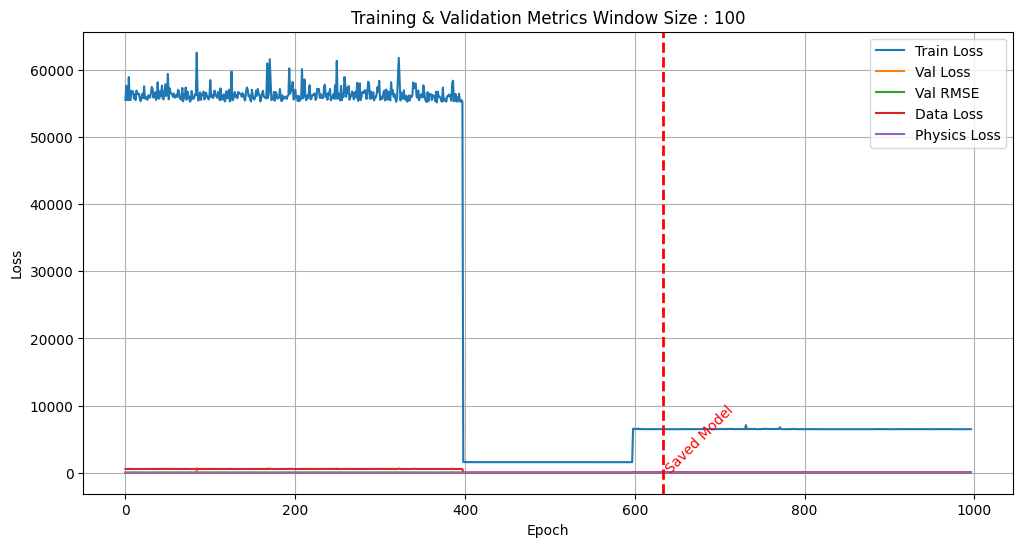

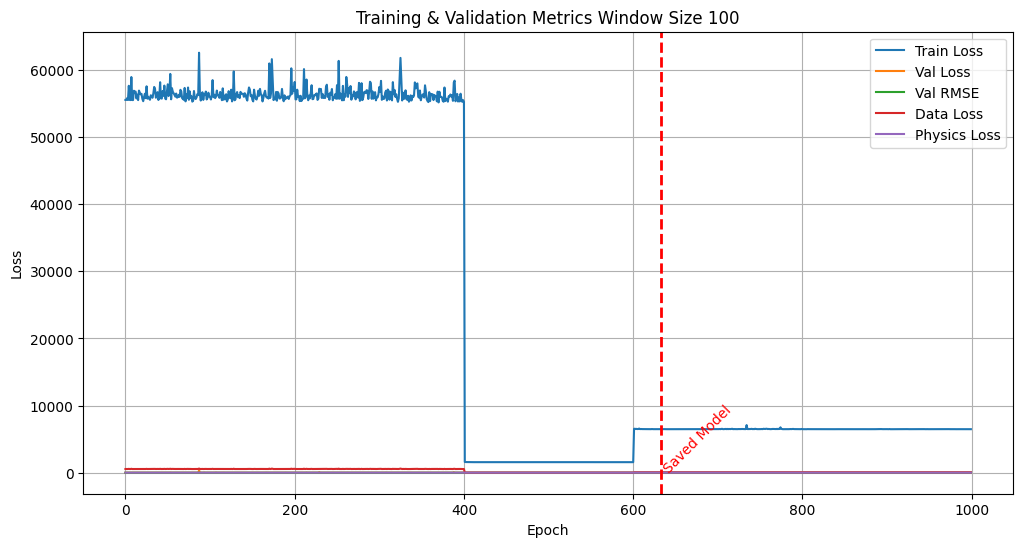

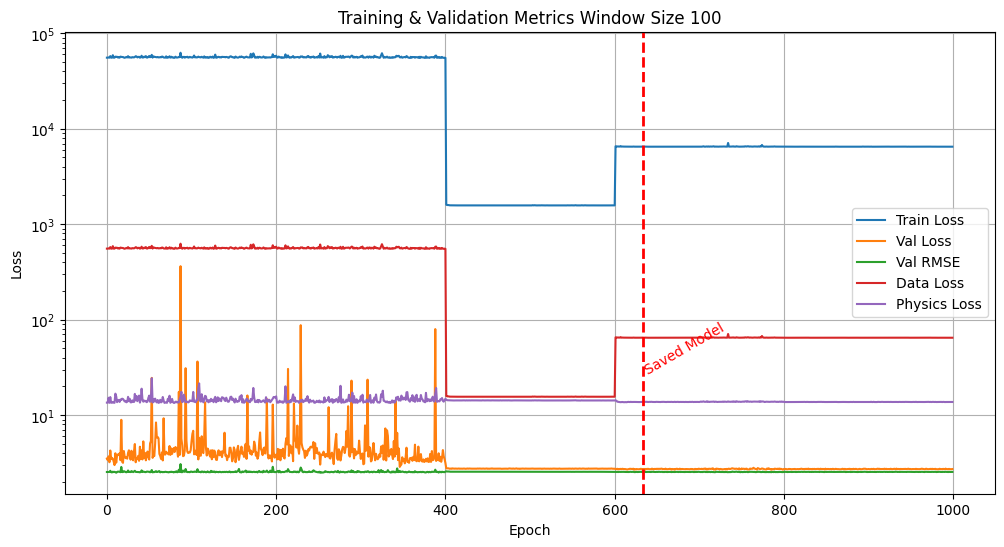

Test RMSE :  8.688520222902298
Cutoff SoH :  0.7
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/3-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/4-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/4-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/4-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/5-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/5-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/7-3-hust_gompertz_params.csv
/kaggle/input/generate-hust

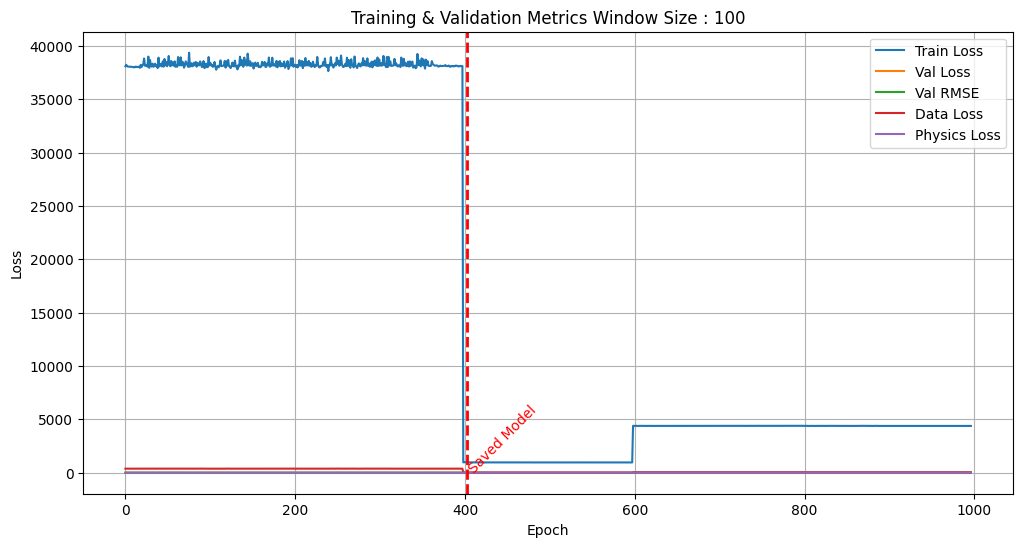

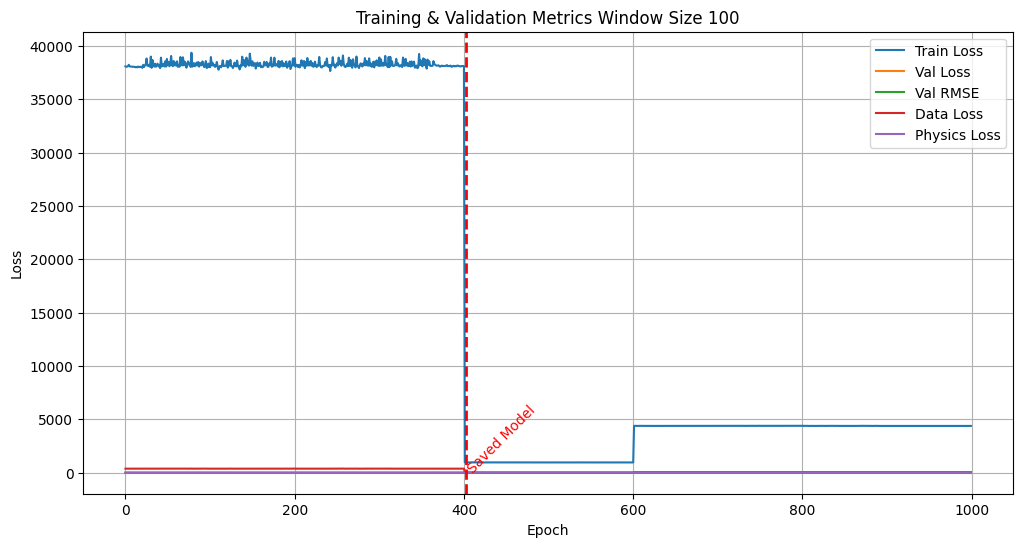

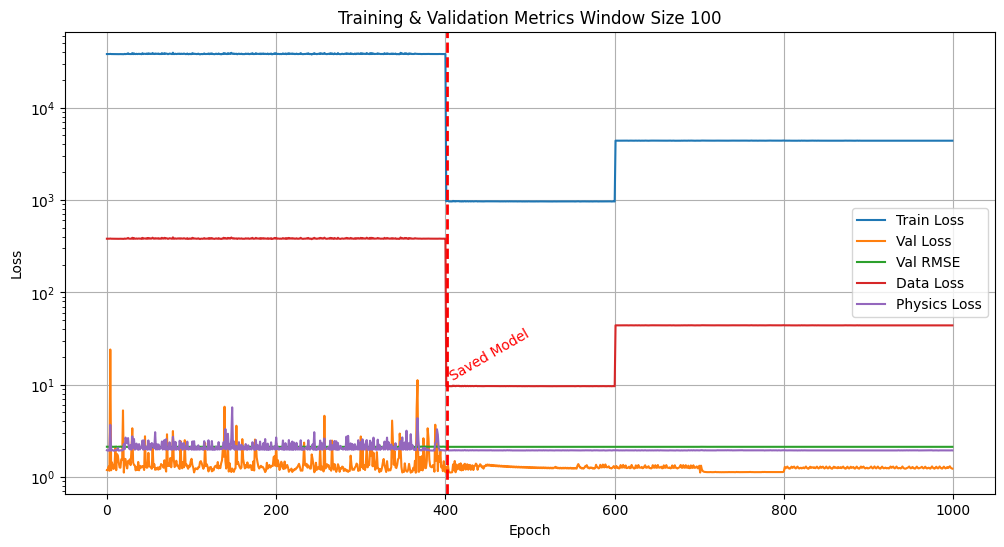

Test RMSE :  2.708770275115967
Cutoff SoH :  0.7
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/3-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/4-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/4-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/5-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/5-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/6-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/6-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/7-1-hust_gompertz_params.csv
/kaggle/input/generate-hust

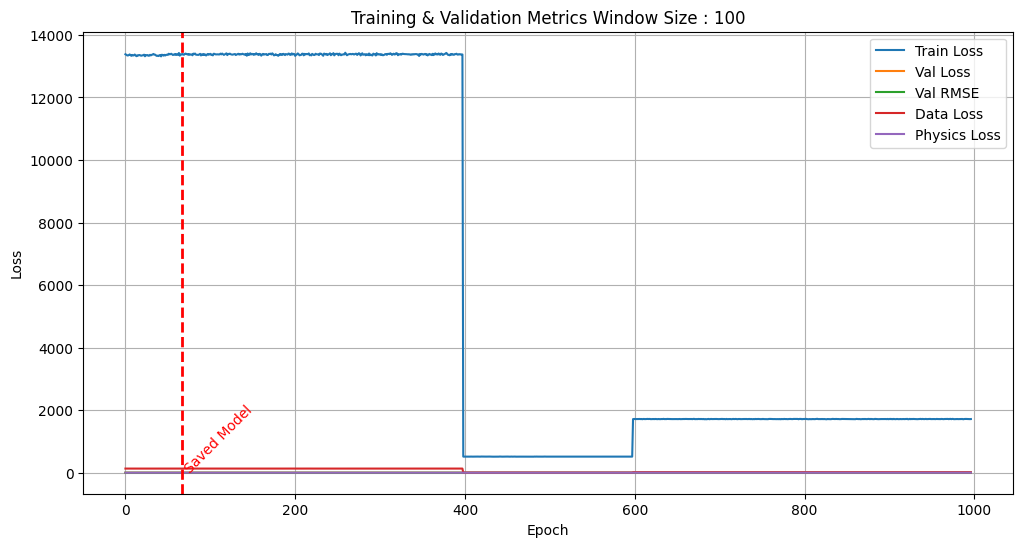

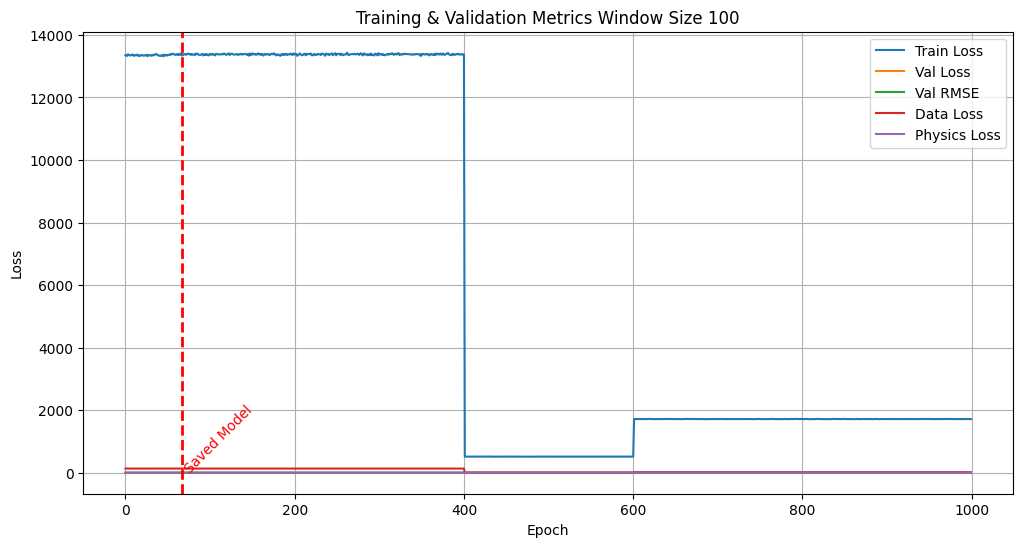

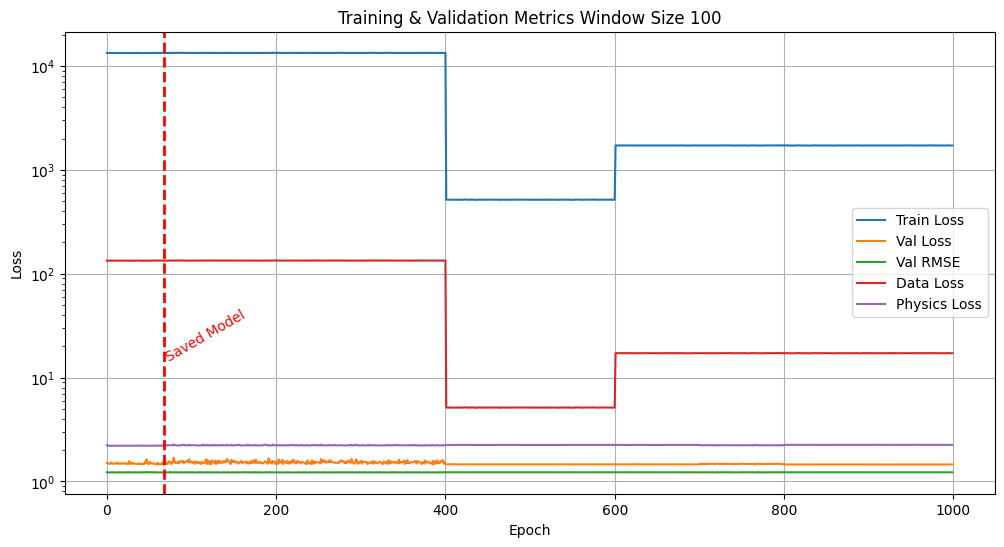

Test RMSE :  1.3764140009880066
Cutoff SoH :  0.7
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/3-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/3-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/3-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/3-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/3-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/4-1-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/4-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/5-1-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/5-6-hust_gompertz_params.csv
/kaggle/input/generate-hus

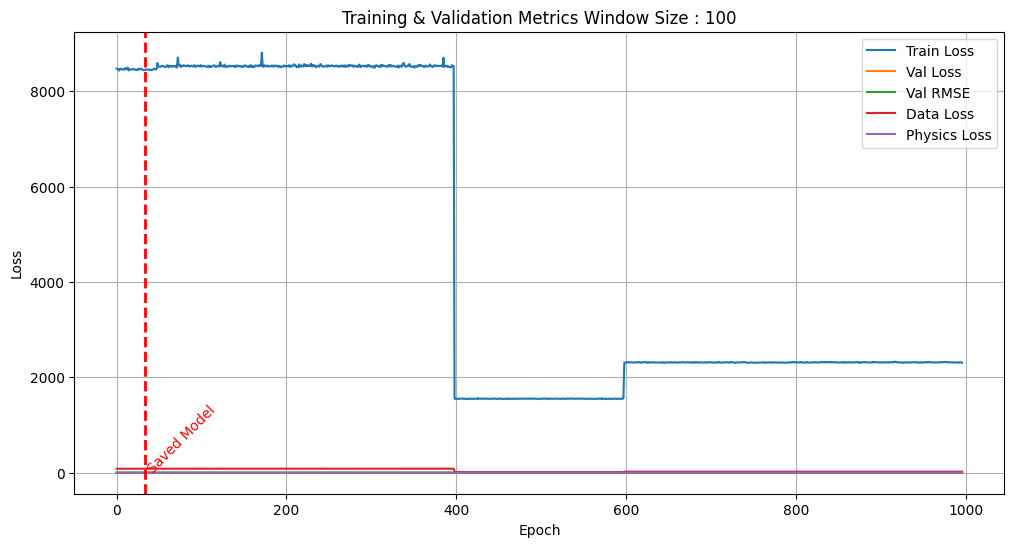

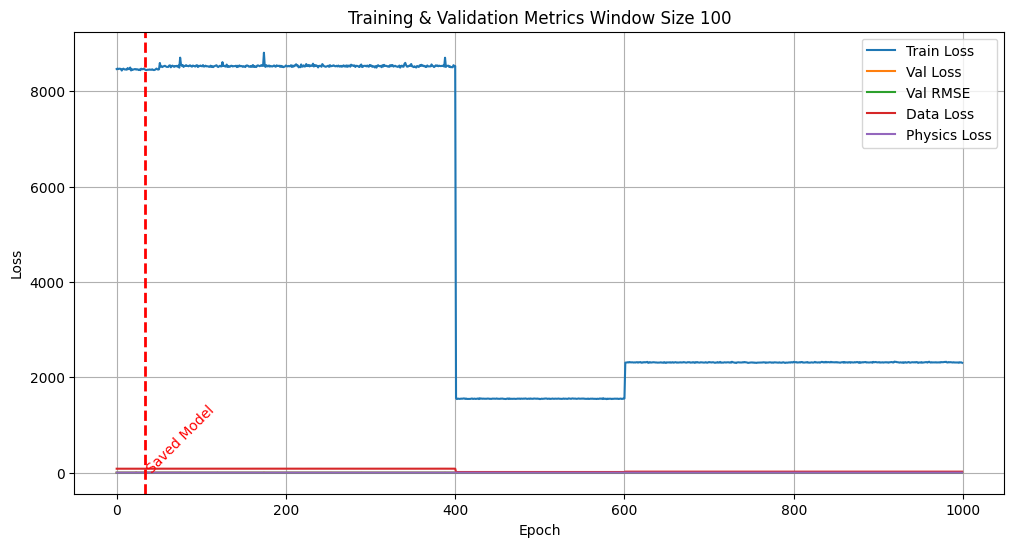

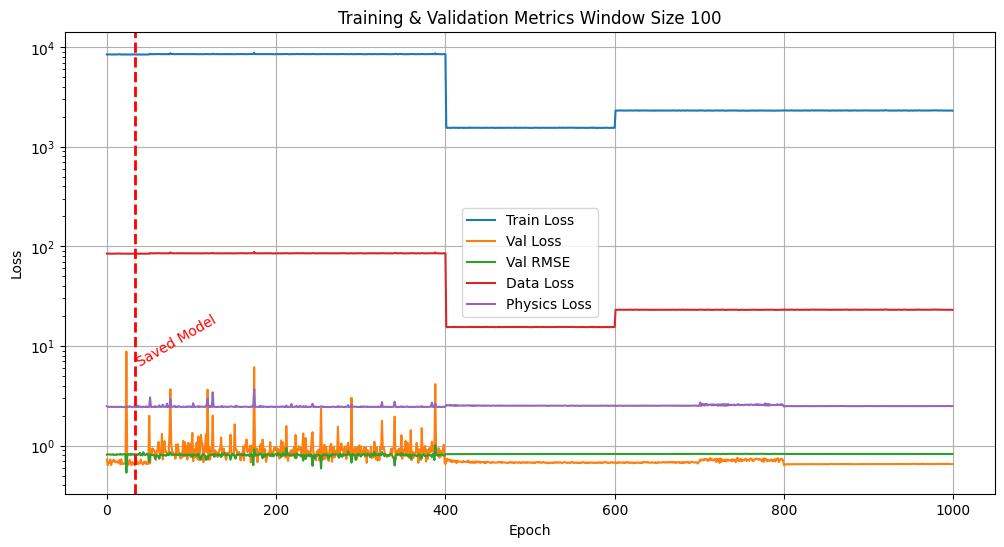

Test RMSE :  1.1435542106628418


In [7]:
data_ranges = ['all','low','mid','high']
for data_range in data_ranges:
    train_model(WINDOW_SIZES,*datasets[data_range],data_range)

In [8]:
# help(TensorDataset)

In [9]:
# # Use X_batch.shape[1] to dynamically get the correct window size (e.g., 6)
# current_batch_size = X_batch.size(0)
# current_window_size = X_batch.size(1) 

# x_seq = torch.arange(current_window_size, dtype=torch.float32, device=X_batch.device)
# x_seq = x_seq.view(1, -1, 1).repeat(current_batch_size, 1, 1) # Shape: [32, 6, 1]

# loss, data_loss, phys_loss = criterion(y_pred, y_batch, x_seq, alpha=0.5)

In [10]:
def df_to_X_y_tensor(df, window_size=5,output_size=5):
    '''
    Converts a time series into (X, y) tensors for LSTM training.
    
    X shape: (num_samples, window_size, 1)
    y shape: (num_samples, 1)
    '''
    # if isinstance(df, (pd.DataFrame, pd.Series)):
    #     df_as_np = df.to_numpy()
    # else:
    #     df_as_np = df  # Assume already numpy

    X, y , y2 = [], [], []
    #for i in range(len(df_as_np) - window_size):
    X.append(list(df['SoH'])[:window_size+1])
    #y.append([df_as_np[i + window_size:i + window_size+output_size]])
    y.append([list(df['k'])[-1],list(df['a'])[-1],list(df['b'])[-1]])
    #append([[val] for val in df_as_np[i + window_size:i + window_size+1]]) #next cycle
    y2.append(list(df['rul'])[:1])
    X,y,y2 = np.array(X),np.array(y), np.array(y2)
    X_tensor = torch.tensor(X, dtype=torch.float32)#.squeeze()
    y_tensor = torch.tensor(y, dtype=torch.float32)#.squeeze()
    y_2_tensor = torch.tensor(y2, dtype=torch.float32)  #bug was here written y instead of y2
    return X_tensor, y_tensor, y_2_tensor

def get_x_y_lists(paths):
    X_list,y_list,y_target = [],[],[]
    for path in paths:
        print(path)
        df = pd.read_csv(path)
        df['Cycle number'] = df['Cycle number']/10000
        df['rul'] = df['rul']/10000
        #normalize SoH
        df['SoH'] =  df['SoH']/soh_normalization_constant
        df.index = df['Cycle number']
        #SoH = df[model_columns]
        X, y , y1 = df_to_X_y_tensor(df, window_size=WINDOW_SIZE,output_size=OUTPUT_SIZE)
        X_list.append(X)
        y_list.append(y)
        y_target.append(y1) #RUL
    return X_list,y_list, y_target



def give_paths_get_loaders(paths,data_type,shuffle=False):
    X_list, y_list, y_target = get_x_y_lists(paths)

    batch_size = torch.cat(X_list, dim=0).shape[0]
    
    if INPUT_SIZE == 1:
        # Concatenate all X and y
        X_1,y_1,y_2 = torch.cat(X_list, dim=0).unsqueeze(-1),torch.cat(y_list, dim=0).view(batch_size,-1),torch.cat(y_target, dim=0).view(batch_size,-1)
    else:
        X_1,y_1,y_2 = torch.cat(X_list, dim=0).squeeze(2),torch.cat(y_list, dim=0).view(-1,INPUT_SIZE),torch.cat(y_target, dim=0).view(-1,INPUT_SIZE)
    
    print(f" X_{data_type} shape : {X_1.shape} , y_{data_type} shape : {y_1.shape} ，y_2{data_type} shape: {y_2.shape}" )
    
    #DataLoader
    print("load : ")
    loader = DataLoader(TensorDataset(X_1, y_1, y_2), batch_size=32, shuffle=shuffle)
    print(f"{data_type}loader lengths : ",loader.__len__())
    return loader,X_1,y_1, y_2

In [11]:
def inverse_gompertz_func(y,k,a,b):
    return (a - np.log(np.log(k/y)))/b

for data_range in data_ranges:
    for WINDOW_SIZE in WINDOW_SIZES:
        WINDOW_SIZE = WINDOW_SIZE - 1
        train_paths,val_paths,test_paths = datasets[data_range]
        train_loader,X_train,y_train,y_train_target= give_paths_get_loaders(train_paths,data_range,shuffle=True)
        val_loader,X_val,y_val,y_val_target= give_paths_get_loaders(val_paths,data_range)
        test_loader,X_test,y_test,y_test_target = give_paths_get_loaders(test_paths,data_range)
    # print(float(torch.mean(y_train, dim=0)[0]),float(torch.mean(y_train, dim=0)[1]),float(torch.mean(y_train, dim=0)[2]))
    # print()
    # print()
    model = PhysicsInformedLSTM(input_size=INPUT_SIZE).to(device)
    model.load_state_dict(torch.load(f'/kaggle/working/best_lstm_model-window-100_model_pinn_data_{data_range}.pth'))
    test_rmse = 0 
    for X_batch, y_batch,y_target in test_loader:
        # Calculate RMSE directly
        
        y_pred = model(X_batch.to(device)).cpu().detach().numpy()
        test_rmse += root_mean_squared_error(y_batch, y_pred)
    print('Test RMSE : ',test_rmse)    
    

    for i, pred in enumerate(y_pred):
        k,a,b,target_rul = y_pred[i][0],y_pred[i][1],y_pred[i][2],y_target[i].item()*10000
        
        print(k,a,b)
        
        print(f'RUL : {inverse_gompertz_func(y=0.7,k=k,a=a,b=b)*10000:.0f} cycles vs Target RUL : {target_rul}')
    print('-'*30)
    print()
    print()

/kaggle/input/generate-hust-data-gompertz-k-a-b/1-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-2-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-3-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-7-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/3-2-hust_gompertz_params.csv

In [12]:
# for sample in train_loader:
#     print(sample)
#     break

In [13]:
# sample[0]

In [14]:
# # help(model)
# for X_batch, y_batch, y_target in train_loader:
#     #optimizer.zero_grad()
#     #Set computing environment
#     X_batch, y_batch = X_batch.to(device), y_batch.to(device)

In [15]:
# model(X_batch)

In [16]:
# X_batch.shape

In [17]:
# y_batch.shape

In [18]:
# X_batch

In [19]:
# for X_batch, y_batch, y_target in test_loader:
#     print(model(X_batch.to(device)))
#     print(y_batch)
#     break

In [20]:
# test_rmse = 0 

# for X_batch, y_batch,y_target in test_loader:
#     # Calculate RMSE directly
#     y_pred = model(X_batch.to(device)).cpu().detach().numpy()
#     test_rmse += root_mean_squared_error(y_batch, y_pred)
# print('Test RMSE : ',test_rmse)

In [21]:
# X_batch

In [22]:
# #['6-6', '8-6', '10-1', '6-8', '8-8', '10-7', '10-6', '7-6', '4-5', '10-4', '3-1', '8-1', '9-6', '1-2', '6-1', '6-2', '8-5', '5-3', '2-5', '9-4', '7-5', '1-1']
# y_batch, y_pred, y_target

In [23]:
# def inverse_gompertz_func(y,k,a,b):
#     return (a - np.log(np.log(k/y)))/b

# for i, pred in enumerate(y_pred):
#     k,a,b,target_rul = y_pred[i][0],y_pred[i][1],y_pred[i][2],y_target[i].item()*10000
    
#     print(k,a,b)
    
#     print(f'RUL : {inverse_gompertz_func(y=0.7,k=k,a=a,b=b)*10000:.0f} cycles vs Target RUL : {target_rul}')

In [24]:
# Define the function
def gompertz_func(x,k,a,b):
    return k*np.exp(-np.exp(a-(b*x)))

def gompertz_exponent_func(x,k,a,b):
    return a-(b*x)

In [25]:
# Check if k,a and b are the correct k, a and b
path = "../input/generate-hust-data-gompertz-k-a-b/"
files = os.listdir(path)
k_s, a_s, b_s ,e_s = [], [],[],[]
#print(files)
files = [f for f in files if re.match(r'^\d', f) and f.endswith('-hust_gompertz_params.csv')]
for file in files:
    df = pd.read_csv(path+file)
    #print(df.head())
    df['exponent'] =  gompertz_exponent_func(x=df['rul']/10000,k=df['k'],a=df['a'],b=df['b'])
    
    answers = file[:3],list(df['k'])[-1], list(df['a'])[-1], list(df['b'])[-1], list(df['exponent'])[-1]
    k_s.append(answers[1]), a_s.append(answers[2]), b_s.append(answers[3]) , e_s.append(answers[4])
    print(answers)

('6-6', 0.999946950696718, -3.0463019901673665, -8.058702298233401, -3.045496119937543)
('8-7', 0.960536968518218, -3.8912779384551865, -13.448726573064285, -3.88993306579788)
('8-6', 0.9907509429027922, -3.6060510716281655, -10.801653050097192, -3.604970906323156)
('9-1', 0.9891766657708968, -3.6505840630566007, -12.21416655437278, -3.6493626464011633)
('10-', 0.9481215769904175, -4.211693705003083, -17.547137063751773, -4.209938991296708)
('6-8', 1.0107420560063778, -2.9030997786747967, -7.691465017103098, -2.9023306321730864)
('8-8', 0.98413059165122, -3.7445201053751354, -15.65627371654888, -3.7429544780034805)
('10-', 0.9786268880932516, -3.700592087534084, -14.445176742202348, -3.6991475698598637)
('3-5', 1.0099262656709476, -3.2992647017070773, -8.637530260413152, -3.298400948681036)
('5-1', 0.9967531041266844, -3.1470462327694158, -8.325162160953383, -3.1462137165533206)
('5-5', 0.9897916363777954, -3.3170924362716403, -14.18101023291364, -3.315674335248349)
('7-1', 0.971157280

In [26]:
min(k_s), max(k_s), min(a_s), max(a_s), min(b_s), max(b_s), min(e_s), max(e_s)

(0.9380190201332748,
 1.176959439132687,
 -4.519553698685354,
 -1.76136905371235,
 -27.431058619993472,
 -4.594320481289704,
 -4.5171884683848,
 -1.760909621664221)

In [27]:
df = pd.read_csv('../input/generate-hust-data-gompertz-k-a-b/hust_gompertz_params.csv')
df['exponent'] = df['a'] - df['b']
print(df[['file','k','a','b','rul']].head(50))
print(df[['file','k','a','b','rul']].tail(27))

        file         k         a          b   rul
0    6-6.csv  0.999947 -3.046302  -8.058702  2468
1    7-8.csv  0.974260 -3.848156 -14.075338  1938
2    5-3.csv  0.984412 -3.370905  -8.364135  2689
3    6-8.csv  1.010742 -2.903100  -7.691465  2450
4    5-5.csv  0.989792 -3.317092 -14.181010  1583
5    2-4.csv  0.966667 -3.666074 -16.745222  1499
6   10-3.csv  0.958764 -3.966747 -14.856416  1848
7    1-4.csv  0.967306 -3.925555 -18.654933  1500
8    6-3.csv  0.980676 -3.726281 -14.527733  1804
9    5-6.csv  0.992200 -3.234754  -8.788364  2460
10   8-3.csv  0.977851 -3.686572 -11.118307  2290
11   3-6.csv  0.985113 -3.474966  -9.437832  2491
12  10-4.csv  0.966029 -4.116645 -16.335191  1811
13   9-6.csv  0.989487 -3.514648 -13.681117  1742
14   3-2.csv  1.000270 -3.217233  -9.342928  2283
15   9-2.csv  0.986816 -3.552345 -11.455414  2143
16   9-7.csv  0.977538 -3.744889 -12.948923  2012
17   6-5.csv  0.971249 -3.576216 -11.063468  2178
18   4-8.csv  0.975867 -3.952479 -16.603498  1706


# Mixture of Experts Ensemble

In [28]:
class GompertzPINN(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model =  base_model
        
        # 1. Freeze the base model
        for param in self.base_model.parameters():
            param.requires_grad = False
        self.base_model.eval()
        
    def inverse_gompertz_layer(self, y, k, a, b):
        # Formula: (a - ln(ln(k/y))) / b
        # Safety: Ensure k/y > 1 to avoid NaN in first log, and ln(k/y) > 0 for second log
        # We clamp ratio to be slightly > 1.0 + epsilon
        ratio = torch.clamp(k / y, min=1.00001)
        
        term1 = torch.log(ratio)
        term2 = torch.log(term1 + 1e-8) # Safety epsilon
        
        rul = (a - term2) / b
        return rul

    def forward(self, x, current_soh=None):
        # 1. Get Parameters (k, a, b) from frozen model
        # Assuming model output is shape (Batch, 3) -> [k, a, b]
        params = self.base_model(x)
        k, a, b = params[:, 0:1], params[:, 1:2], params[:, 2:3]
        
        # # 2. Get Current SoH (y)
        # # If not provided, grab the last value from the input window
        # # Assuming x shape is (Batch, Window, Features) and SoH is Feature 0
        # if current_soh is None:
        #     current_soh = x[:, -1, 0].unsqueeze(1)

        # 3. Predict RUL
        rul = self.inverse_gompertz_layer(0.7, k, a, b)*10000
        return rul, k, a, b

In [29]:
# # Create 3 independent PINNs
# pinn_low  = GompertzPINN(f'best_lstm_model-window-100_model_pinn_data_{data_ranges[1]}.pth')
# pinn_mid  = GompertzPINN(f'best_lstm_model-window-100_model_pinn_data_{data_ranges[2]}.pth')
# pinn_high = GompertzPINN(f'best_lstm_model-window-100_model_pinn_data_{data_ranges[3]}.pth')
WINDOW_SIZE = 99
def load_and_wrap_model(weight_path):
    # 1. Initialize the empty architecture
    # Make sure INPUT_SIZE matches what you used during training
    model = PhysicsInformedLSTM(input_size=INPUT_SIZE).to('cpu')
    
    # 2. Load the weights from the file
    # We use map_location='cpu' to be safe, then move to device later
    model.load_state_dict(torch.load(weight_path, map_location='cpu'))
    
    # 3. Wrap it in the Physics/Gompertz layer
    pinn_wrapper = GompertzPINN(base_model=model)
    
    return pinn_wrapper.to('cpu')

# --- Usage ---

# 1. Define your paths
path_low  = f'best_lstm_model-window-100_model_pinn_data_{data_ranges[1]}.pth'
path_mid  = f'best_lstm_model-window-100_model_pinn_data_{data_ranges[2]}.pth'
path_high = f'best_lstm_model-window-100_model_pinn_data_{data_ranges[3]}.pth'

# 2. Create the 3 independent PINNs correctly
pinn_low  = load_and_wrap_model(path_low)
pinn_mid  = load_and_wrap_model(path_mid)
pinn_high = load_and_wrap_model(path_high)

print("✅ Models loaded and wrapped successfully!")

train_paths,val_paths,test_paths = datasets[data_ranges[0]]
test_loader,X_test,y_test,y_test_target = give_paths_get_loaders(test_paths,data_ranges[0])

for X_batch, y_batch,y_target in test_loader:
    break

# Usage
with torch.no_grad():
    rul_l, k_l, a_l, b_l = pinn_low(X_batch[0].unsqueeze(0))
    rul_m, k_m, a_m, b_m = pinn_mid(X_batch[0].unsqueeze(0))
    rul_h, k_h, a_h, b_h = pinn_high(X_batch[0].unsqueeze(0))
print(y_batch[0],y_target[0])
print(f"Low Model says: {rul_l.item():.2f}--------------{k_l, a_l, b_l}")
print(f"Mid Model says: {rul_m.item():.2f}--------------{k_m, a_m, b_m}")
print(f"High Model says: {rul_h.item():.2f}--------------{k_h, a_h, b_h}")

✅ Models loaded and wrapped successfully!
/kaggle/input/generate-hust-data-gompertz-k-a-b/9-4-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/10-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/7-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/3-1-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/8-8-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/4-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/8-1-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/8-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/7-6-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/2-5-hust_gompertz_params.csv
/kaggle/input/generate-hust-data-gompertz-k-a-b/1-1-hust_gompertz_params.csv
 X_all shape : torch.Size([11, 100, 1]) , y_all shape : torch.Size([11, 3]) ，y_2all shape: torch.Size([11, 1])

In [30]:
model = PhysicsInformedLSTM(input_size=INPUT_SIZE).to(device)
model.load_state_dict(torch.load(f'/kaggle/working/best_lstm_model-window-100_model_pinn_data_{data_ranges[1]}.pth'))
for param in model.parameters():
    param.requires_grad = False
model.eval()
model(X_batch.to(device))

tensor([[  0.9536,  -3.9243, -19.2441],
        [  0.9536,  -3.9242, -19.2439],
        [  0.9537,  -3.9243, -19.2442],
        [  0.9537,  -3.9243, -19.2441],
        [  0.9537,  -3.9243, -19.2441],
        [  0.9537,  -3.9243, -19.2444],
        [  0.9538,  -3.9243, -19.2446],
        [  0.9536,  -3.9243, -19.2441],
        [  0.9538,  -3.9243, -19.2446],
        [  0.9537,  -3.9243, -19.2444],
        [  0.9538,  -3.9243, -19.2447]], device='cuda:0')

# Train Mixture of Experts Model

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. The MoE Model Architecture ---
class TrainableGompertzMoE(nn.Module):
    def __init__(self, model_low, model_mid, model_high, input_dim=1, window_size=100):
        super().__init__()
        
        # Load Experts
        self.expert_low = model_low
        self.expert_mid = model_mid
        self.expert_high = model_high
        
        # # Freeze Experts (We only train the Gate)
        # self.freeze_expert(self.expert_low)
        # self.freeze_expert(self.expert_mid)
        # self.freeze_expert(self.expert_high)
        # Partially Freeze Experts
        # We freeze the LSTM (the "Brain") but train the FC (the "Mouth")
        self.partial_freeze(self.expert_low)
        self.partial_freeze(self.expert_mid)
        self.partial_freeze(self.expert_high)
        
        # Gating Network (The Router)
        # Decides which expert to trust based on the input curve
        self.gate = nn.Sequential(
            nn.Flatten(),
            nn.Linear(window_size * input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3), 
        )
        
    def freeze_expert(self, model):
        for param in model.parameters():
            param.requires_grad = False
        model.eval()

    def partial_freeze(self, model):
        # 1. Freeze EVERYTHING first
        for param in model.parameters():
            param.requires_grad = False
            
        # 2. Unfreeze ONLY the Final Layer (self.fc)
        # This assumes your expert class has a layer named 'fc'
        for param in model.fc.parameters():
            param.requires_grad = True
            
        # 3. Set mode (Keep LSTM in eval mode to disable Dropout randomness in the feature extractor)
        model.eval()

    def inverse_gompertz_layer(self, y, k, a, b):
        # RUL = (a - ln(ln(k/y))) / b
        # Safety Clamping
        ratio = torch.clamp(k / y, min=1.0001)
        term1 = torch.log(ratio)
        term2 = torch.log(torch.clamp(term1, min=1e-6)) 
        rul = (a - term2) / (b - 1e-6)
        return rul

    def forward(self, x):
        # x: [Batch, Window, Features]
        
        # 1. Get Expert Predictions
        out_l = self.expert_low(x) # [Batch, 3]
        out_m = self.expert_mid(x)
        out_h = self.expert_high(x)
        
        expert_outputs = torch.stack([out_l, out_m, out_h], dim=1) # [Batch, 3, 3]
        
        # 2. Get Gate Weights
        logits = self.gate(x) # [Batch, 3]
        temperature = 5.0 # <--- The Magic Number. Start with 2.0 or 5.0
        weights = F.softmax(logits * temperature, dim=1)
        # 3. Weighted Average of Parameters
        # bmm: Batch Matrix Multiply
        weighted_params = torch.bmm(weights.unsqueeze(1), expert_outputs).squeeze(1)
        
        k_pred = weighted_params[:, 0:1]
        a_pred = weighted_params[:, 1:2]
        b_pred = weighted_params[:, 2:3]

        # 4. Calculate RUL
        rul_pred = self.inverse_gompertz_layer(0.7, k_pred, a_pred, b_pred)
        
        return rul_pred, k_pred, a_pred, b_pred, weights

# --- 2. The MoE Loss Function ---
def direct_rul_loss(pred_rul, true_rul, weights, pred_params, true_params):
    """
    Optimizes for RUL accuracy while keeping parameters sane.
    """
    # 1. RUL Error (Primary Goal) - Robust Huber Loss
    rul_loss = F.smooth_l1_loss(pred_rul, true_rul)
    
    # 2. Parameter Consistency (Secondary Goal)
    # Ensures the weighted k,a,b aren't wildly different from the single-model targets
    param_loss = F.mse_loss(pred_params, true_params)
    
    # 3. Entropy Regularization
    # Encourages the gate to be decisive (pick one expert) rather than averaging all 3
    entropy_loss = -torch.mean(torch.sum(weights * torch.log(weights + 1e-8), dim=1))
    
    # Weights: RUL is king (1.0), Params help guide (0.1), Entropy for sharpness (0.01)
    total_loss = (10000.0 * rul_loss) + (0.01 * param_loss) + (0.001 * entropy_loss)
    
    return total_loss, rul_loss.item()

In [32]:
def train_moe_model(WINDOW_SIZES, train_paths, val_paths, test_paths, path_low, path_mid, path_high):
    
    # --- Helper: Data Preparation (Your Original Code) ---
    def df_to_X_y_tensor(df, window_size=5, output_size=5):
        X, y , y2 = [], [], []
        # Create sequences
        # Note: Ideally iterate carefully to avoid index errors, assuming your data is pre-padded or sufficient
        df_vals = df['SoH'].values
        df_k = df['k'].values
        df_a = df['a'].values
        df_b = df['b'].values
        df_rul = df['rul'].values
        
        # Optimized loop
        # for i in range(len(df) - window_size):
        X.append(df_vals[i : i + window_size])
        # Target params at the END of the window
        y.append([df_k[-1], df_a[-1], df_b[-1]])
        # Target RUL at the END of the window
        y2.append(df_rul[:1]) #list(df['rul'])[:1]

        X = np.array(X)[..., np.newaxis] # Add feature dim
        y = np.array(y)
        y2 = np.array(y2)
        
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), torch.tensor(y2, dtype=torch.float32)

    def get_x_y_lists(paths, w_size):
        X_list, y_list, y_target = [], [], []
        for path in paths:
            df = pd.read_csv(path)
            # Normalization (ensure these match your previous training!)
            df['Cycle number'] = df['Cycle number'] / 10000
            df['rul'] = df['rul'] / 10000 
            df['SoH'] = df['SoH'] # Assuming SoH is already 0-1 or normalized externally
            
            X, y, y1 = df_to_X_y_tensor(df, window_size=w_size)
            X_list.append(X)
            y_list.append(y)
            y_target.append(y1)
        return X_list, y_list, y_target

    def give_paths_get_loaders(paths, w_size, shuffle=False):
        X_list, y_list, y_target = get_x_y_lists(paths, w_size)
        
        # Concatenate
        X_cat = torch.cat(X_list, dim=0)
        y_cat = torch.cat(y_list, dim=0)
        y_tar_cat = torch.cat(y_target, dim=0)
        
        print(f"Dataset Shape: X={X_cat.shape}, Param_Y={y_cat.shape}, RUL_Y={y_tar_cat.shape}")
        
        loader = DataLoader(TensorDataset(X_cat, y_cat, y_tar_cat), batch_size=32, shuffle=shuffle)
        return loader

    # --- Helper: Load Base Model ---
    def load_base_model(path, input_size):
        # Ensure this matches your generic PhysicsInformedLSTM class definition
        model = PhysicsInformedLSTM(input_size=input_size) 
        model.load_state_dict(torch.load(path, map_location=device))
        return model

    # --- MAIN LOOP ---
    for WINDOW_SIZE in WINDOW_SIZES:
        #WINDOW_SIZE = WINDOW_SIZE + 1 
        print(f"\n🚀 STARTING TRAINING FOR WINDOW SIZE: {WINDOW_SIZE}")
        
        # 1. Prepare Data
        train_loader = give_paths_get_loaders(train_paths, WINDOW_SIZE, shuffle=True)
        val_loader   = give_paths_get_loaders(val_paths, WINDOW_SIZE, shuffle=False)
        test_loader  = give_paths_get_loaders(test_paths, WINDOW_SIZE, shuffle=False)
        
        # 2. Initialize Experts & MoE
        print("Loading Experts...")
        INPUT_SIZE = 1 # Assuming SoH only
        expert_low  = load_base_model(path_low, INPUT_SIZE)
        expert_mid  = load_base_model(path_mid, INPUT_SIZE)
        expert_high = load_base_model(path_high, INPUT_SIZE)
        
        model = TrainableGompertzMoE(
            expert_low, expert_mid, expert_high, 
            input_dim=INPUT_SIZE, window_size=WINDOW_SIZE
        ).to(device)
        
        # 3. Optimizer (Only train the Gate!)
        optimizer = torch.optim.Adam(model.gate.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)
        
        # 4. Metrics Setup
        best_val_loss = float('inf')
        train_history = []
        val_history = []
        
        # 5. Training Loop
        num_epochs = 1000 # MoE converges faster than raw LSTM
        
        for epoch in range(num_epochs):
            model.train()
            total_train_loss = 0
            total_rul_error = 0
            
            for X_batch, y_params_batch, y_rul_batch in train_loader:
                X_batch = X_batch.to(device)
                y_params_batch = y_params_batch.to(device)
                y_rul_batch = y_rul_batch.to(device)
                
                optimizer.zero_grad()
                
                # Forward Pass
                pred_rul, pred_k, pred_a, pred_b, gate_weights = model(X_batch)
                
                # Combined Params for loss calculation
                pred_params = torch.cat([pred_k, pred_a, pred_b], dim=1)
                
                # Loss Calculation
                loss, rul_l1 = direct_rul_loss(pred_rul, y_rul_batch, gate_weights, pred_params, y_params_batch)
                
                loss.backward()
                optimizer.step()
                
                total_train_loss += loss.item()
                total_rul_error += rul_l1
                
            avg_train_loss = total_train_loss / len(train_loader)
            avg_rul_error = total_rul_error / len(train_loader)
            
            # --- Validation ---
            model.eval()
            total_val_loss = 0
            val_rmse_accum = 0
            
            with torch.no_grad():
                for X_val, y_params_val, y_rul_val in val_loader:
                    X_val = X_val.to(device)
                    y_params_val = y_params_val.to(device)
                    y_rul_val = y_rul_val.to(device)
                    
                    pred_rul, k, a, b, w = model(X_val)
                    pred_params = torch.cat([k, a, b], dim=1)
                    
                    loss, _ = direct_rul_loss(pred_rul, y_rul_val, w, pred_params, y_params_val)
                    
                    # RMSE Calculation
                    mse = F.mse_loss(pred_rul, y_rul_val)
                    val_rmse_accum += torch.sqrt(mse).item()
                    total_val_loss += loss.item()
            
            avg_val_loss = total_val_loss / len(val_loader)
            avg_val_rmse = val_rmse_accum / len(val_loader)
            
            # Adjust LR
            scheduler.step(avg_val_loss)
            
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | RUL L1: {avg_rul_error:.4f} | Val Loss: {avg_val_loss:.4f} | Val RMSE: {avg_val_rmse:.4f}")
            
            # Save Best
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), f"best_moe_model_window_{WINDOW_SIZE}.pth")
                print("✅ Saved Best MoE Model")
                
        # 6. Final Test
        print("\n--- Running Final Test ---")
        model.load_state_dict(torch.load(f"best_moe_model_window_{WINDOW_SIZE}.pth"))
        model.eval()
        test_rmse_total = 0
        with torch.no_grad():
            for X_test, _, y_rul_test in test_loader:
                X_test = X_test.to(device)
                y_rul_test = y_rul_test.to(device)
                
                pred_rul, _, _, _, _ = model(X_test)
                mse = F.mse_loss(pred_rul, y_rul_test)
                test_rmse_total += torch.sqrt(mse).item()
        
        print(f"🏆 Final Test RMSE for Window {WINDOW_SIZE}: {test_rmse_total / len(test_loader):.4f}")
        # return test_loader

In [33]:
data_ranges = ['all','low','mid','high']

train_moe_model(WINDOW_SIZES,*datasets['all'],'best_lstm_model-window-100_model_pinn_data_low.pth','best_lstm_model-window-100_model_pinn_data_mid.pth','best_lstm_model-window-100_model_pinn_data_high.pth')


🚀 STARTING TRAINING FOR WINDOW SIZE: 100
Dataset Shape: X=torch.Size([55, 100, 1]), Param_Y=torch.Size([55, 3]), RUL_Y=torch.Size([55, 1])
Dataset Shape: X=torch.Size([11, 100, 1]), Param_Y=torch.Size([11, 3]), RUL_Y=torch.Size([11, 1])
Dataset Shape: X=torch.Size([11, 100, 1]), Param_Y=torch.Size([11, 3]), RUL_Y=torch.Size([11, 1])
Loading Experts...
Epoch 1/1000 | Train Loss: 7.1404 | RUL L1: 0.0007 | Val Loss: 12.5243 | Val RMSE: 0.0499
✅ Saved Best MoE Model
Epoch 2/1000 | Train Loss: 7.2429 | RUL L1: 0.0007 | Val Loss: 12.9315 | Val RMSE: 0.0507
Epoch 3/1000 | Train Loss: 6.8409 | RUL L1: 0.0007 | Val Loss: 12.1277 | Val RMSE: 0.0491
✅ Saved Best MoE Model
Epoch 4/1000 | Train Loss: 6.8844 | RUL L1: 0.0007 | Val Loss: 11.2576 | Val RMSE: 0.0473
✅ Saved Best MoE Model
Epoch 5/1000 | Train Loss: 7.0949 | RUL L1: 0.0007 | Val Loss: 10.7518 | Val RMSE: 0.0462
✅ Saved Best MoE Model
Epoch 6/1000 | Train Loss: 7.1126 | RUL L1: 0.0007 | Val Loss: 10.5488 | Val RMSE: 0.0458
✅ Saved Best 


🔍 Starting Testing Inference...

🏆 Final Test RMSE: 0.0377
📉 Final Test MAE:  0.0323


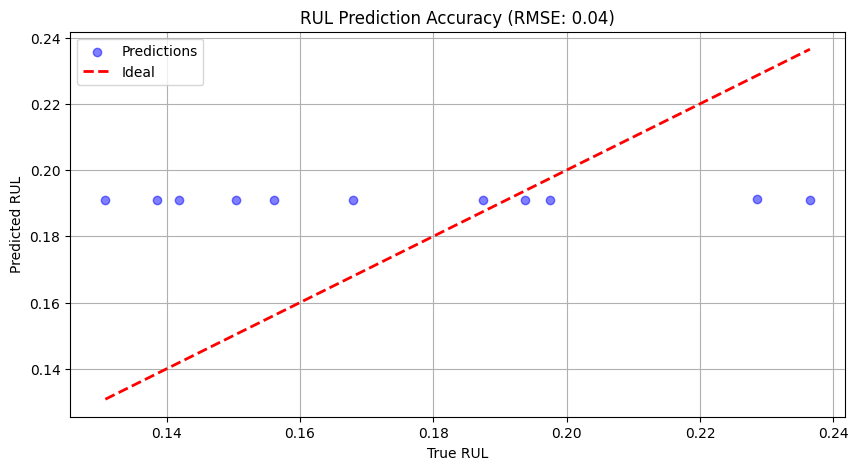

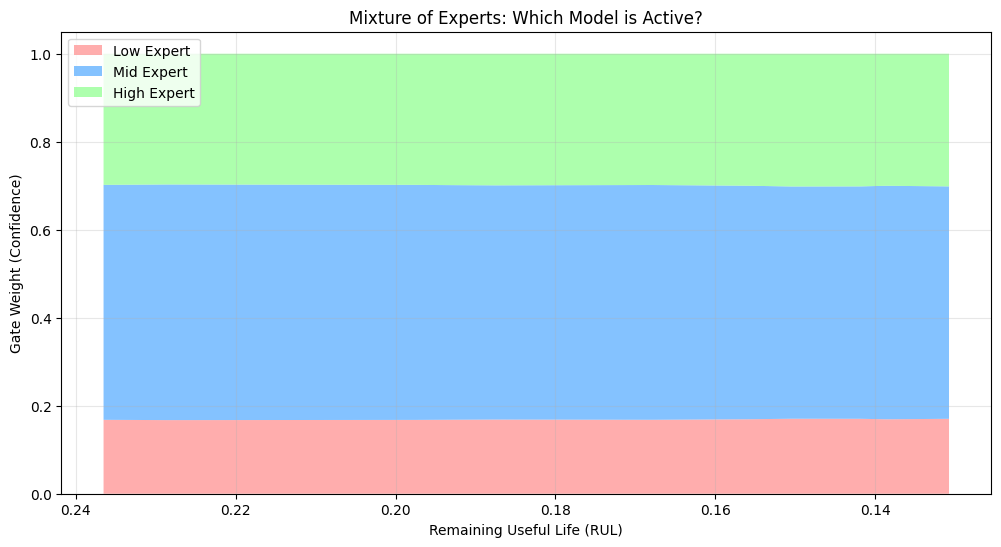


🔬 Sample Breakdown (Interpretability Check):
True RUL   | Pred RUL   | Low W    | Mid W    | High W   | Decision
---------------------------------------------------------------------------
0.13       | 0.19       | 0.17     | 0.53     | 0.30     | Mid
0.19       | 0.19       | 0.17     | 0.53     | 0.30     | Mid
0.15       | 0.19       | 0.17     | 0.53     | 0.30     | Mid
0.24       | 0.19       | 0.17     | 0.53     | 0.30     | Mid
0.17       | 0.19       | 0.17     | 0.53     | 0.30     | Mid


In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


def load_base_model(path, input_size):
    # Ensure this matches your generic PhysicsInformedLSTM class definition
    model = PhysicsInformedLSTM(input_size=input_size) 
    model.load_state_dict(torch.load(path, map_location=device))
    return model
        
def test_and_visualize(model, test_loader, device):
    model.eval()
    
    # Storage for analysis
    all_true_rul = []
    all_pred_rul = []
    all_weights = [] # To store [w_low, w_mid, w_high]
    all_soh = []     # To see at what SoH the model switches experts
    
    print("\n🔍 Starting Testing Inference...")
    
    with torch.no_grad():
        for X_batch, _, y_rul_batch in test_loader:
            X_batch = X_batch.to(device)
            y_rul_batch = y_rul_batch.to(device)
            
            # Forward pass
            pred_rul, k, a, b, weights = model(X_batch)
            
            # Store results (Move to CPU for plotting)
            all_true_rul.extend(y_rul_batch.cpu().numpy().flatten())
            all_pred_rul.extend(pred_rul.cpu().numpy().flatten())
            all_weights.extend(weights.cpu().numpy())
            
            # Store the current SoH (last step of input window)
            # Assuming SoH is feature 0
            current_soh = X_batch[:, -1, 0].cpu().numpy()
            all_soh.extend(current_soh)

    # Convert to numpy arrays
    all_true_rul = np.array(all_true_rul)
    all_pred_rul = np.array(all_pred_rul)
    all_weights = np.array(all_weights) # Shape: [N_samples, 3]
    all_soh = np.array(all_soh)

    # --- 1. Calculate Metrics ---
    rmse = np.sqrt(mean_squared_error(all_true_rul, all_pred_rul))
    mae = mean_absolute_error(all_true_rul, all_pred_rul)
    print(f"\n🏆 Final Test RMSE: {rmse:.4f}")
    print(f"📉 Final Test MAE:  {mae:.4f}")

    # --- 2. Visualization: Prediction vs Actual ---
    plt.figure(figsize=(10, 5))
    plt.scatter(all_true_rul, all_pred_rul, alpha=0.5, color='blue', label='Predictions')
    plt.plot([min(all_true_rul), max(all_true_rul)], [min(all_true_rul), max(all_true_rul)], 'r--', lw=2, label='Ideal')
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"RUL Prediction Accuracy (RMSE: {rmse:.2f})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 3. Visualization: Expert Selection (The "Brain" of the MoE) ---
    # We sort by RUL to see how expert usage changes as battery degrades
    sort_idx = np.argsort(all_true_rul)
    sorted_rul = all_true_rul[sort_idx]
    sorted_weights = all_weights[sort_idx]

    plt.figure(figsize=(12, 6))
    plt.stackplot(sorted_rul, 
                  sorted_weights[:, 0], # Low Expert
                  sorted_weights[:, 1], # Mid Expert
                  sorted_weights[:, 2], # High Expert
                  labels=['Low Expert', 'Mid Expert', 'High Expert'],
                  colors=['#ff9999', '#66b3ff', '#99ff99'], 
                  alpha=0.8)
    
    plt.xlabel("Remaining Useful Life (RUL)")
    plt.ylabel("Gate Weight (Confidence)")
    plt.title("Mixture of Experts: Which Model is Active?")
    plt.legend(loc='upper left')
    plt.gca().invert_xaxis() # High RUL on left (Fresh), Low RUL on right (Dead)
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- 4. Deep Dive: Inspect 5 Random Samples ---
    print("\n🔬 Sample Breakdown (Interpretability Check):")
    indices = np.random.choice(len(all_true_rul), 5, replace=True)
    
    print(f"{'True RUL':<10} | {'Pred RUL':<10} | {'Low W':<8} | {'Mid W':<8} | {'High W':<8} | {'Decision'}")
    print("-" * 75)
    
    for idx in indices:
        t_rul = all_true_rul[idx]
        p_rul = all_pred_rul[idx]
        w = all_weights[idx]
        
        # Determine dominant expert
        expert_names = ['Low', 'Mid', 'High']
        dominant = expert_names[np.argmax(w)]
        
        print(f"{t_rul:<10.2f} | {p_rul:<10.2f} | {w[0]:<8.2f} | {w[1]:<8.2f} | {w[2]:<8.2f} | {dominant}")

# --- How to Run It ---
# 1. Load your best saved model structure
# (Ensure expert_low/mid/high are loaded as done in training)
WINDOW_SIZE =100
expert_low, expert_mid, expert_high = load_base_model('best_lstm_model-window-100_model_pinn_data_low.pth', INPUT_SIZE),load_base_model('best_lstm_model-window-100_model_pinn_data_mid.pth', INPUT_SIZE),load_base_model('best_lstm_model-window-100_model_pinn_data_high.pth', INPUT_SIZE)
model = TrainableGompertzMoE(expert_low, expert_mid, expert_high, input_dim=1, window_size=WINDOW_SIZE).to(device)
model.load_state_dict(torch.load(f"best_moe_model_window_{WINDOW_SIZE}.pth"))



# test_loader  = give_paths_get_loaders(test_paths, WINDOW_SIZE, shuffle=False)
# 2. Run the test
test_and_visualize(model, test_loader, device)

In [35]:
!ls

best_lstm_model-window-100_model_pinn_data_all.pth
best_lstm_model-window-100_model_pinn_data_high.pth
best_lstm_model-window-100_model_pinn_data_low.pth
best_lstm_model-window-100_model_pinn_data_mid.pth
best_moe_model_window_100.pth
history-from-3-window_99_model_pinn.png
history-full-log-window_99_model_pinn.png
history-full-window_99_model_pinn.png
last_model_window_100_model_pinn_data_all.pth
last_model_window_100_model_pinn_data_high.pth
last_model_window_100_model_pinn_data_low.pth
last_model_window_100_model_pinn_data_mid.pth
__notebook__.ipynb
training_metrics__window_99_model_pinn.npz


In [36]:
# test_loader

In [37]:
# for X_batch, _, y_rul_batch in test_loader:
#     pass